<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/PART_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [![DOI](https://zenodo.org/badge/357586333.svg)](https://zenodo.org/badge/latestdoi/357586333) -->

Change DOI HERE

#**PART II**

Part II of code for *Unsaturated zone water storage regulates recharge to groundwater and subsequent runoff response in seasonally dry California basins*.

---



**Load packages.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime
import requests
import os
import json
import urllib
import warnings
from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.collections import LineCollection
matplotlib_axes_logger.setLevel('ERROR')
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
%config InlineBackend.figure_format = 'retina'

**Mount Google Drive.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  To mount Drive, find the file name of the folder you wish to connect to.  By default, files are saved to user's "My Drive" dashboard.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)  # Change folder name here

Mounted at /content/drive


**Load data.**  Load filtered catchment data (output of *Filter Catchments, Calculate Recharge and the Root-Zone Storage Deficit*) and attributes (output of *Summary of Catchment Hydrogeology*) from Google Drive.

In [3]:
# Connect to folder created in "PART I"
path = "/content/drive/My Drive/recharge_deficit/"

# Catchment data
df_gages = pd.read_csv(path + "filtered_catchment_data.csv")
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)
df_gages = df_gages.loc['2000-10-01':'2020-10-01']

# Catchment attributes
df_attr = pd.read_csv(path + "catchment_attributes.csv")
df_attr.set_index('USGS Gage ID',inplace=True,drop=True)
df_attr.index = df_attr.index.astype('str')

#**1. Water year cumulative timeseries**

Plot the extended cumulative water year timeseries for Elder Creek (USGS Gage ID 11475560), Bull Creek (11476600), and Big Creek (11284400).  Plot the response of cumulative recharge to cumulative precipitation alongside the recharge ratio.

In [4]:
def timeseries_plot(df_gage,ax,xlim=False,legend=True):
  """Cumulative timeseries of selected catchment.

  Parameters
  ----------
  df_gage : DataFrame containing catchment data.
  ax : Figure axis to plot on.
  xlim (optional) : X-limit of axes.
  legend (bool) : Controls whether legend is shown (True) or not (False)
  ----------
  """
  # Cumulative time series by water year
  df_gage.groupby('wateryear')['ppt'].cumsum().plot(ax=ax, label=r'$\sum{P}$', x_compat=True, color='tab:blue', zorder=-1)
  df_gage.groupby('wateryear')['q'].cumsum().plot(ax=ax, label=r'$\sum{Q}$', x_compat=True, color='tab:orange', linestyle='dashed', zorder=1)
  # df_gage.groupby('wateryear')['rt'].cumsum().plot(ax=ax, label=r'$\sum{R}$', x_compat=True, color='darkviolet', zorder=2)
  df_gage.groupby('wateryear')['et'].cumsum().plot(ax=ax, label=r'$\sum{ET}$', x_compat=True, color='tab:green', linestyle='dotted',zorder=0)
  df_gage['D'].plot(ax=ax, label=r'$D$', kind='area', color='tab:red', alpha=0.3, zorder=-2)

  # Format x-axis ticks and labels
  xtick_wy = []
  xlabel_wy = []
  for wateryear in list(set(df_gage.wateryear.values)):
    xtick_wy.append('10-01-%s'%str(wateryear))
    xlabel_wy.append('Oct. %s'%str(wateryear))
  ax.set_xticks(ticks=xtick_wy)
  ax.set_xticklabels(xlabel_wy)#,rotation=90,ha='center')

  # Add legend, set the axis limits, axis labels, and title
  ax.legend(ncol=4,bbox_to_anchor=[0.55,0.9], loc='center', handletextpad=1, fontsize=9)
  ax.set_ylim(bottom=0)
  if xlim == False:  ax.set_xlim([df_gage.index.min(),df_gage.index.max()])
  else: ax.set_xlim([xlim[0],xlim[1]])
  ax.set(xlabel = "End of Water Year", ylabel = "Hydrologic flux [mm]")

  # Add grid, remove spines, adjust layout
  ax.grid(alpha=0.2, axis='y')

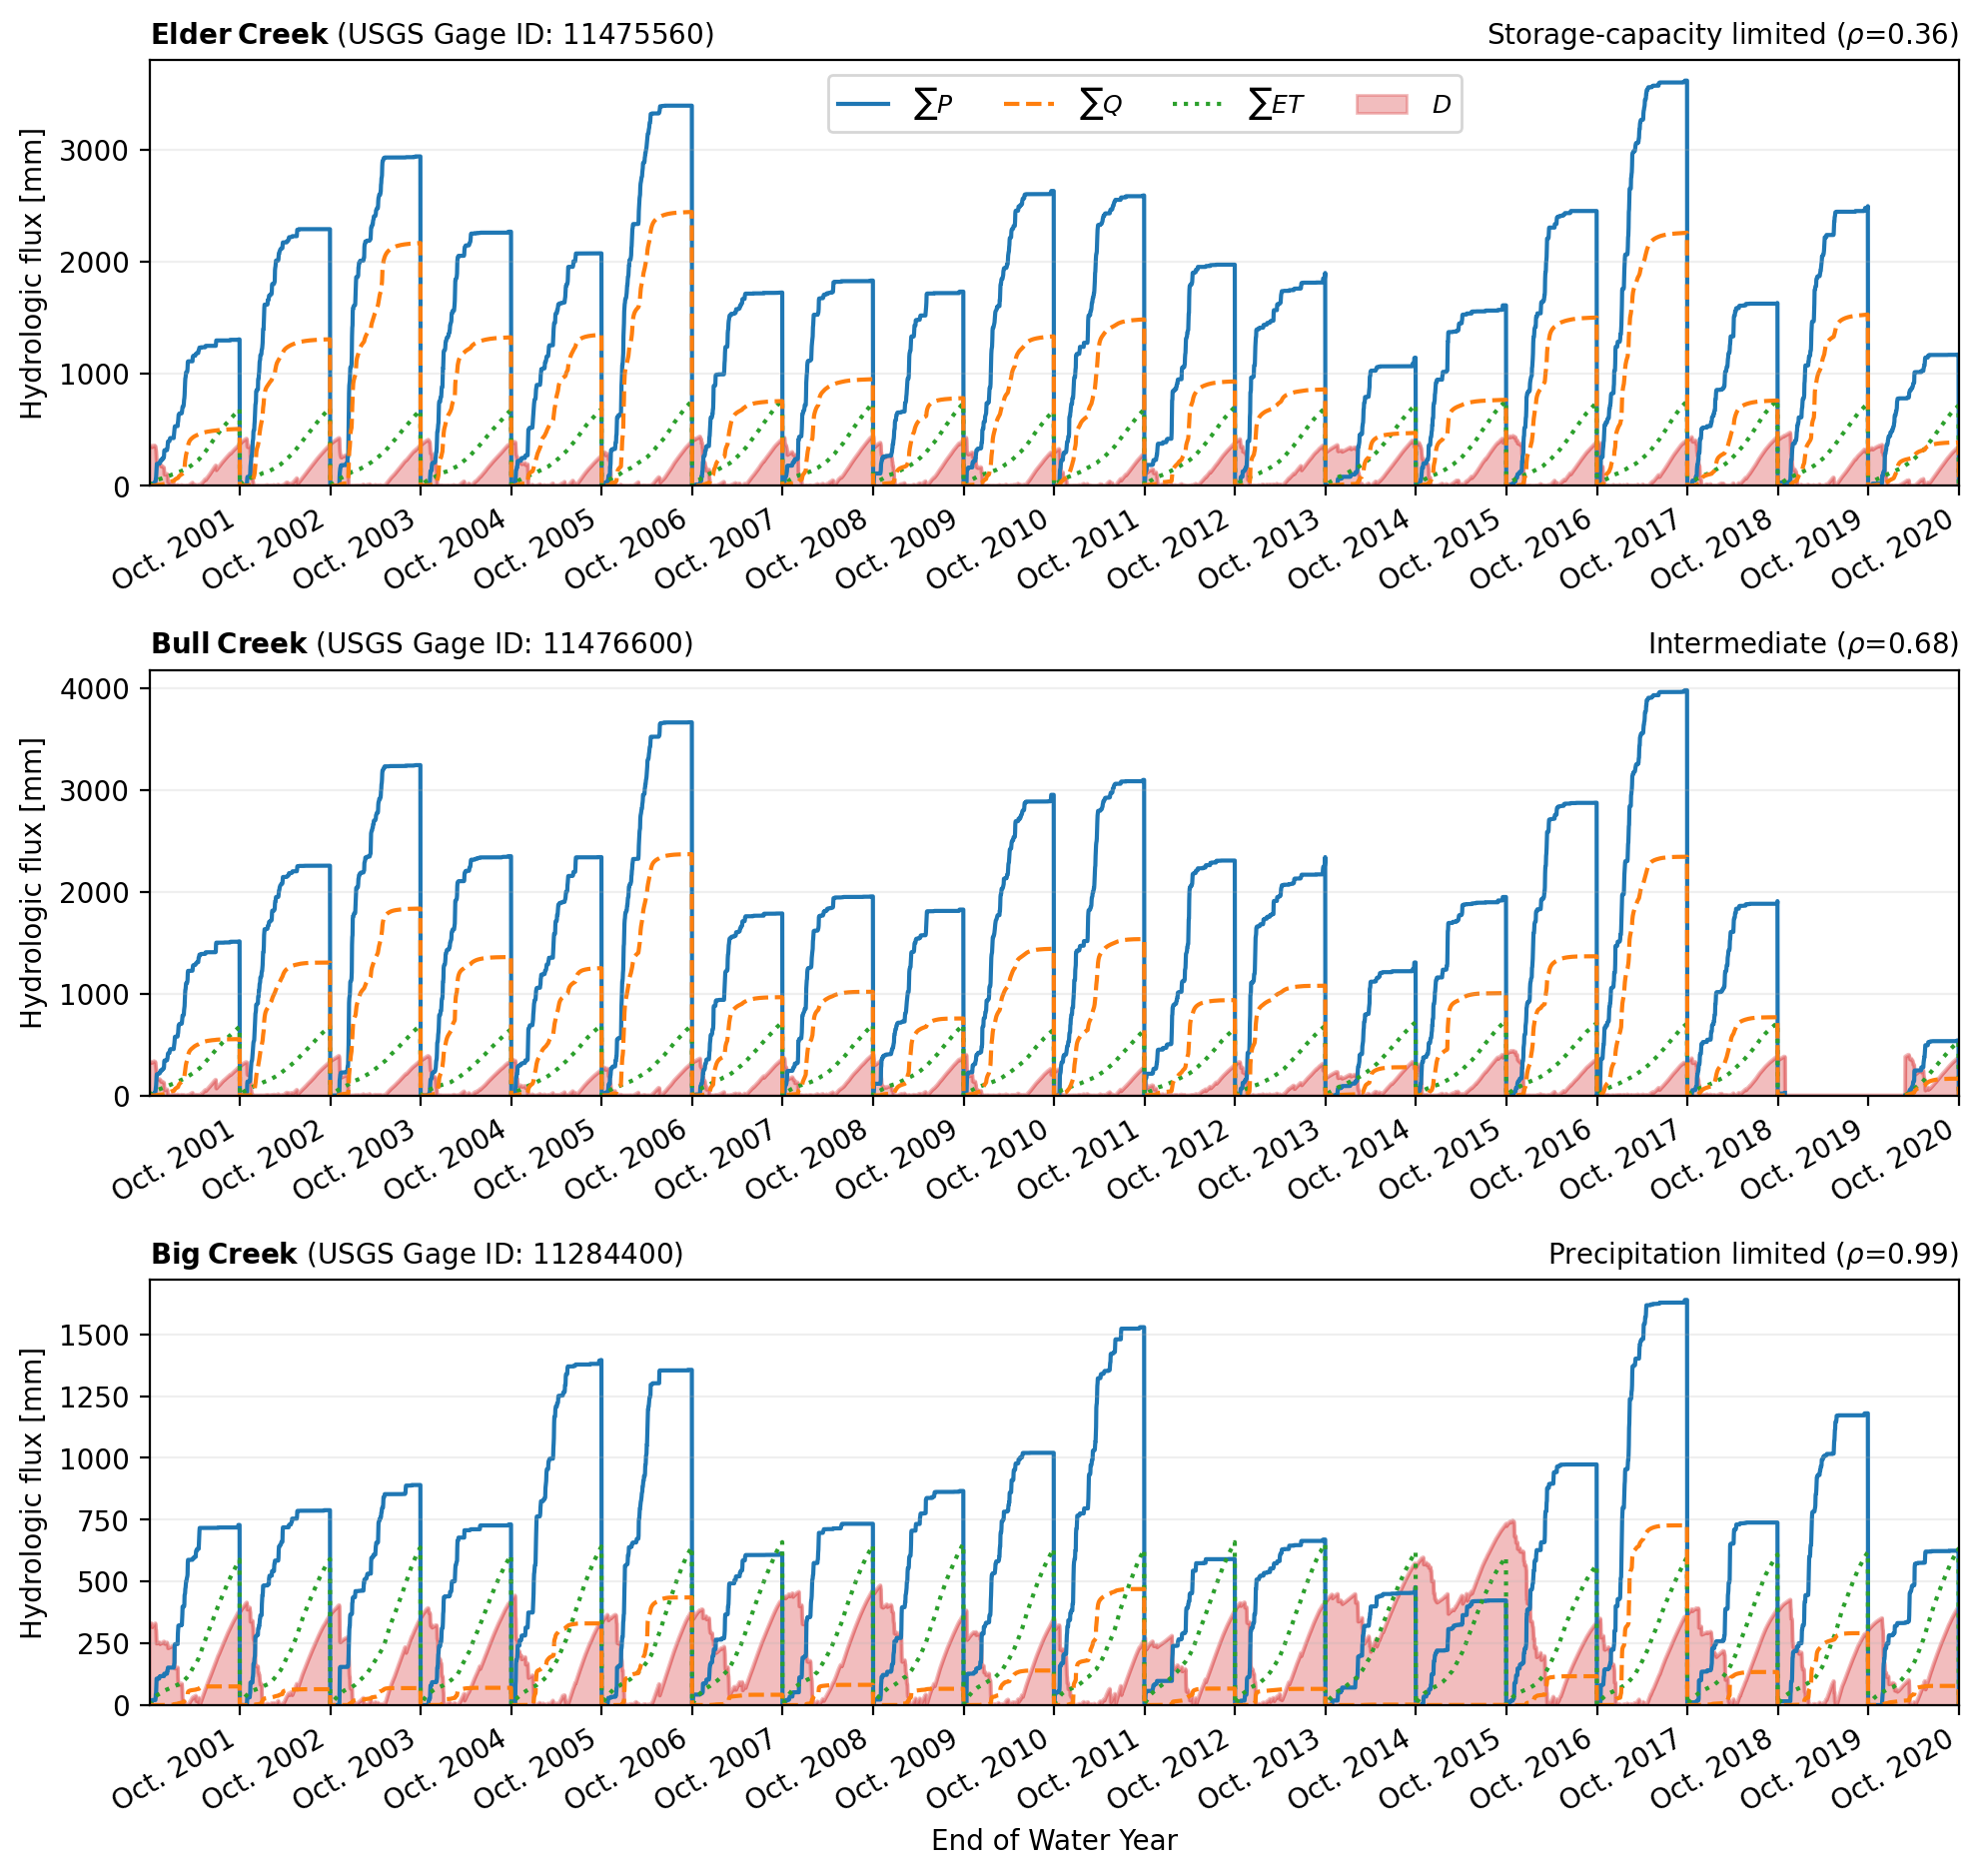

In [5]:
# Plotting space
fig,axs = plt.subplots(3,1,figsize=(10,9.5))

# USGS Gage ID
Elder_ck = '11475560'
Bull_ck = '11476600'
Big_ck = '11284400'
gages = [Elder_ck,Bull_ck,Big_ck]

# Water year cumulative timeseries
for gage, ax in zip(gages,axs):
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages['wateryear'])
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  timeseries_plot(df_gage,ax=ax)

# Axis handling, appearance
axs[0].set(xlabel="")
axs[1].set(xlabel="")
axs[1].legend().remove()
axs[2].legend().remove()
axs[0].set_title(r"$\bf{Elder\hspace{0.25}Creek}$"+" (USGS Gage ID: 11475560)", loc='left', fontsize=10)
axs[0].set_title("Storage-capacity limited "+r"($\rho$=0.36)", loc='right', fontsize=10)
axs[1].set_title(r"$\bf{Bull\hspace{0.25}Creek}$"+" (USGS Gage ID: 11476600)", loc='left', fontsize=10)
axs[1].set_title("Intermediate "+r"($\rho$=0.68)", loc='right', fontsize=10)
axs[2].set_title(r"$\bf{Big\hspace{0.25}Creek}$"+" (USGS Gage ID: 11284400)", loc='left', fontsize=10)
axs[2].set_title("Precipitation limited "+r"($\rho$=0.99)", loc='right', fontsize=10)

# Figure layout
fig.tight_layout()

#**1.5 Multi-year deficit**

**Define functions.**

In [6]:
def first_rainfall(df):
  """Find the datetime of the first storm event occuring after the start
  of the precipitation time series.  Return DataFrame after first rainfall.

  Parameters
  ----------
  df : DataFrame with np.datetime64 index containing precipitation time series (column name = 'ppt') in mm.

  Returns
  ----------
  df : DataFrame containing data after first rainfall.
  """
  first_rain = df.loc[df['ppt']>=2].index[0]
  lag = pd.Timedelta(days=2)
  while first_rain <= df.index[0]+lag:
    df = df[first_rain+lag:]
    first_rain = df.loc[df['ppt']>=2].index[0]
  return df[first_rain:]


def logistic(x, L, x0, k):
  """Logistic function for fitting data."""
  return (-(L*np.log(k + np.exp(k*x0)*k)) + L*np.log(np.exp(k*x)*k + np.exp(k*x0)*k))/k


def logistic_fit(xdata,ydata,ax,ratio=False):
  """Fit data with logistic function and plot.

  Parameters
  ----------
  xdata : Numpy array or list containing x-data to be fit
  ydata : Numpy array or list containing y-data to be fit
  ax : Figure axis to plot on
  ratio (default=False) : When true, plots recharge ratio instead of cumulative recharge on y-axis

  Returns
  popt (list) : Results of logistic fit.
  coefficient_of_determination (float) : Coefficient of determination from logistic fit
  ----------
  """
  # Check data is in the form of a 1xn array, flatten
  xdata = np.array(xdata).flatten()
  ydata = np.array(ydata).flatten()
  # Identify where x and y are finite, sort based on xdata
  idx = np.where(np.isfinite(xdata)&np.isfinite(ydata))[0]
  xdata, ydata = (np.array(t) for t in zip(*sorted(zip(xdata[idx], ydata[idx]))))
  # Translate x-axis to positive coordinate space
  offset = abs(np.min(xdata))
  xdata = xdata+offset
  # Fit logistic function
  p0 = [1,100,0.01]
  popt,pcov = curve_fit(logistic, xdata, ydata,p0,maxfev=10000)
  xvar = np.linspace(np.min(xdata),np.max(xdata),1000)
  # Return x-axis to original coordinate space and plot
  coefficient_of_determination = r2_score(ydata,logistic(xdata, *popt))
  x = xvar-offset
  y = logistic(xvar, *popt) if ratio==False else logistic(xvar, *popt)/(x)
  ax.plot(x,y, c='dodgerblue',label=r"$\int \mathrm{Sigmoid}$ fit, $\mathrm{r^2}$ = %.2f"%coefficient_of_determination, lw=1.25, zorder=-1)
  return popt, coefficient_of_determination


def recharge_plot(df_gages,gage,ax,ratio=False,show_where_deficit_resets=False,inset=False,legend=True,highlight_wys=[]):
  """Plots cumulative recharge or recharge ratio vs. cumulative precipitation.

  Parameters
  ----------
  df_gages : DataFrame containing combined gage data for all study catchments.
  gage : USGS gage ID corresponding to catchment (str)
  ax : Figure axis to plot on.
  ratio (default=False) : When true, plots recharge ratio on y-axis instead of cumulative recharge
  show_where_deficit_resets (default=False) : Plots up to deficit being reset, skips water years when deficit is not reset
  legend (default=True) : When true, legend is included in plot.
  inset (default=False) : When true, axis is formatted as an inset plot.
  highlight_wys (optional) : List containing water years (as integer) to highlight.
  ---------
  """
  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']])
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)

  # Extract winter hydrology
  winter_months = [10,11,12,1,2,3]
  df_winter = df_gage[df_gage.index.month.isin(winter_months)]

  # Define wateryears, colors, marker
  wateryears = np.unique(df_winter['wateryear'].to_numpy())
  cs = sns.color_palette('bright',len(wateryears)) #iter(['#ffffcc','#a1dab4','#41b6c4','#225ea8'])
  markers = iter(["o","^","s","v"])

  # Plot recharge for each wateryear, apply logistic fit
  xdata = np.array([])
  ydata = np.array([])
  for i, wateryear in enumerate(wateryears):
    if wateryear < 2001 or wateryear > 2020:
      break
    # Identify first rainfall of water year
    df_year = first_rainfall(df_winter[df_winter['wateryear']==wateryear])
    # Identify when deficit is reset
    if show_where_deficit_resets==True:
      deficit_reset = df_year.loc[df_year['D']<=0.1].index
      if len(deficit_reset)>0:
        df_deficit = df_year.loc[:deficit_reset[0]].cumsum()
        x_to_deficit_reset = df_deficit['ppt']
        y_to_deficit_reset = df_deficit['rt'] if ratio==False else df_deficit['rt']/df_deficit['ppt']
      else:
        x_to_deficit_reset = []
        y_to_deficit_reset = []
    x = df_year['ppt'].cumsum()
    y = df_year['rt'].cumsum() if ratio==False else df_year['rt'].cumsum()/df_year['ppt'].cumsum()

    # Transparency
    if wateryear in highlight_wys:
      color=cs[i]; edgecolor='k'; alpha = 1; zorder = 1; lw = 2; marker=next(markers); label="%s wy"%str(wateryear) #next(cs)
    else:
      color='darkgray'; edgecolor=None; alpha = 0.5; zorder = -1; lw = 1; marker="o"; label=None
    # Recharge or recharge ratio on y-axis
    if ratio == False:
      if show_where_deficit_resets==True:
        ax.plot(x_to_deficit_reset, y_to_deficit_reset, color=color, alpha=alpha, zorder=zorder, linewidth=lw, label="%s before deficit resets"%str(wateryear)) # Plot recharge for water year
        ax.plot(x, y, color=color, alpha=0.8, zorder=-1, linewidth=lw, label="%s after deficit resets"%str(wateryear)) # Plot recharge for water year
        try:
          ax.scatter(np.max(x_to_deficit_reset), np.max(y_to_deficit_reset), color=color, edgecolor=edgecolor, s=30, alpha=alpha, zorder=zorder, label=label)
        except:
          continue
      else:
        ax.plot(x, y, color=color, alpha=alpha, zorder=zorder, linewidth=lw, label=label) # Plot recharge for water year
        ax.scatter(np.max(x), np.max(y), color=color, edgecolor=edgecolor, marker=marker, s=30, alpha=alpha, zorder=zorder, label=label)
    else:
      if show_where_deficit_resets==True:
        try:
          ax.scatter(np.max(x_to_deficit_reset), np.max(y_to_deficit_reset), color=color, edgecolor='k', marker=marker, s=30, alpha=alpha, zorder=zorder, label=label)
        except:
          continue
      else: ax.scatter(np.max(x), np.max(y), color=color, edgecolor=edgecolor, marker=marker, s=30, alpha=alpha, zorder=zorder, label=label)
    xdata = np.append(xdata,x)
    ydata = np.append(ydata,df_year['rt'].cumsum())

  # Fit data with logistic function
  try:
    popt, coefficient_of_determination = logistic_fit(xdata,ydata,ax,ratio=ratio)
  except:
    print("Could not fit logistic function to gage %s"%gage)

  # 1:1 lines
  ymin, ymax = ax.get_ylim()
  xmin, xmax = ax.get_xlim()
  if ratio==False and inset==False:
    cepts = np.arange(-10*ymax,ymax,max([xmax/4,ymax/4]))
    for cept in cepts[:-1]:
      ax.plot([0,ymax - cept],[cept,ymax],c='k',ls='--',alpha=0.5,lw=0.5)
    cept = cepts[-1]
    ax.plot([0,ymax - cept],[cept,ymax],c='k',ls='--',alpha=0.5,lw=0.5)

  # Inflection point for recharge ratio
  if ratio==True:
    ax.axhline(y=popt[0]/2, c='k', ls='--', lw=0.8, label="Inflection")

  # Legend handling
  if legend==True:
    # Reorder legend
    handles, labels = ax.get_legend_handles_labels()
    order = [len(handles)-2, len(handles)-1,*range(len(handles)-2)]#[len(handles)-1, *range(len(handles)-1)]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left',frameon=False,fontsize=8)

  # General housekeeping
  if inset==False:
    if ratio==False:
      ylabel = "Cumulative wet season\nrecharge [mm]"
      xlim=[0,np.nanmax(xdata)]
      ylim=[0,np.nanmax(ydata)]
    else:
      ylabel = "Wet season\nrecharge ratio [mm/mm]"
      xlim=[50,np.nanmax(xdata)]
      ylim=[0,1]
    ax.set(xlabel="Cumulative wet season\nprecipitation [mm]", ylabel=ylabel, xlim=xlim, ylim=ylim)
  else:
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

**Plot the early winter "ramp-up" and runoff ratio for each catchment.**

<ipython-input-7-e30b89d01ca0>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


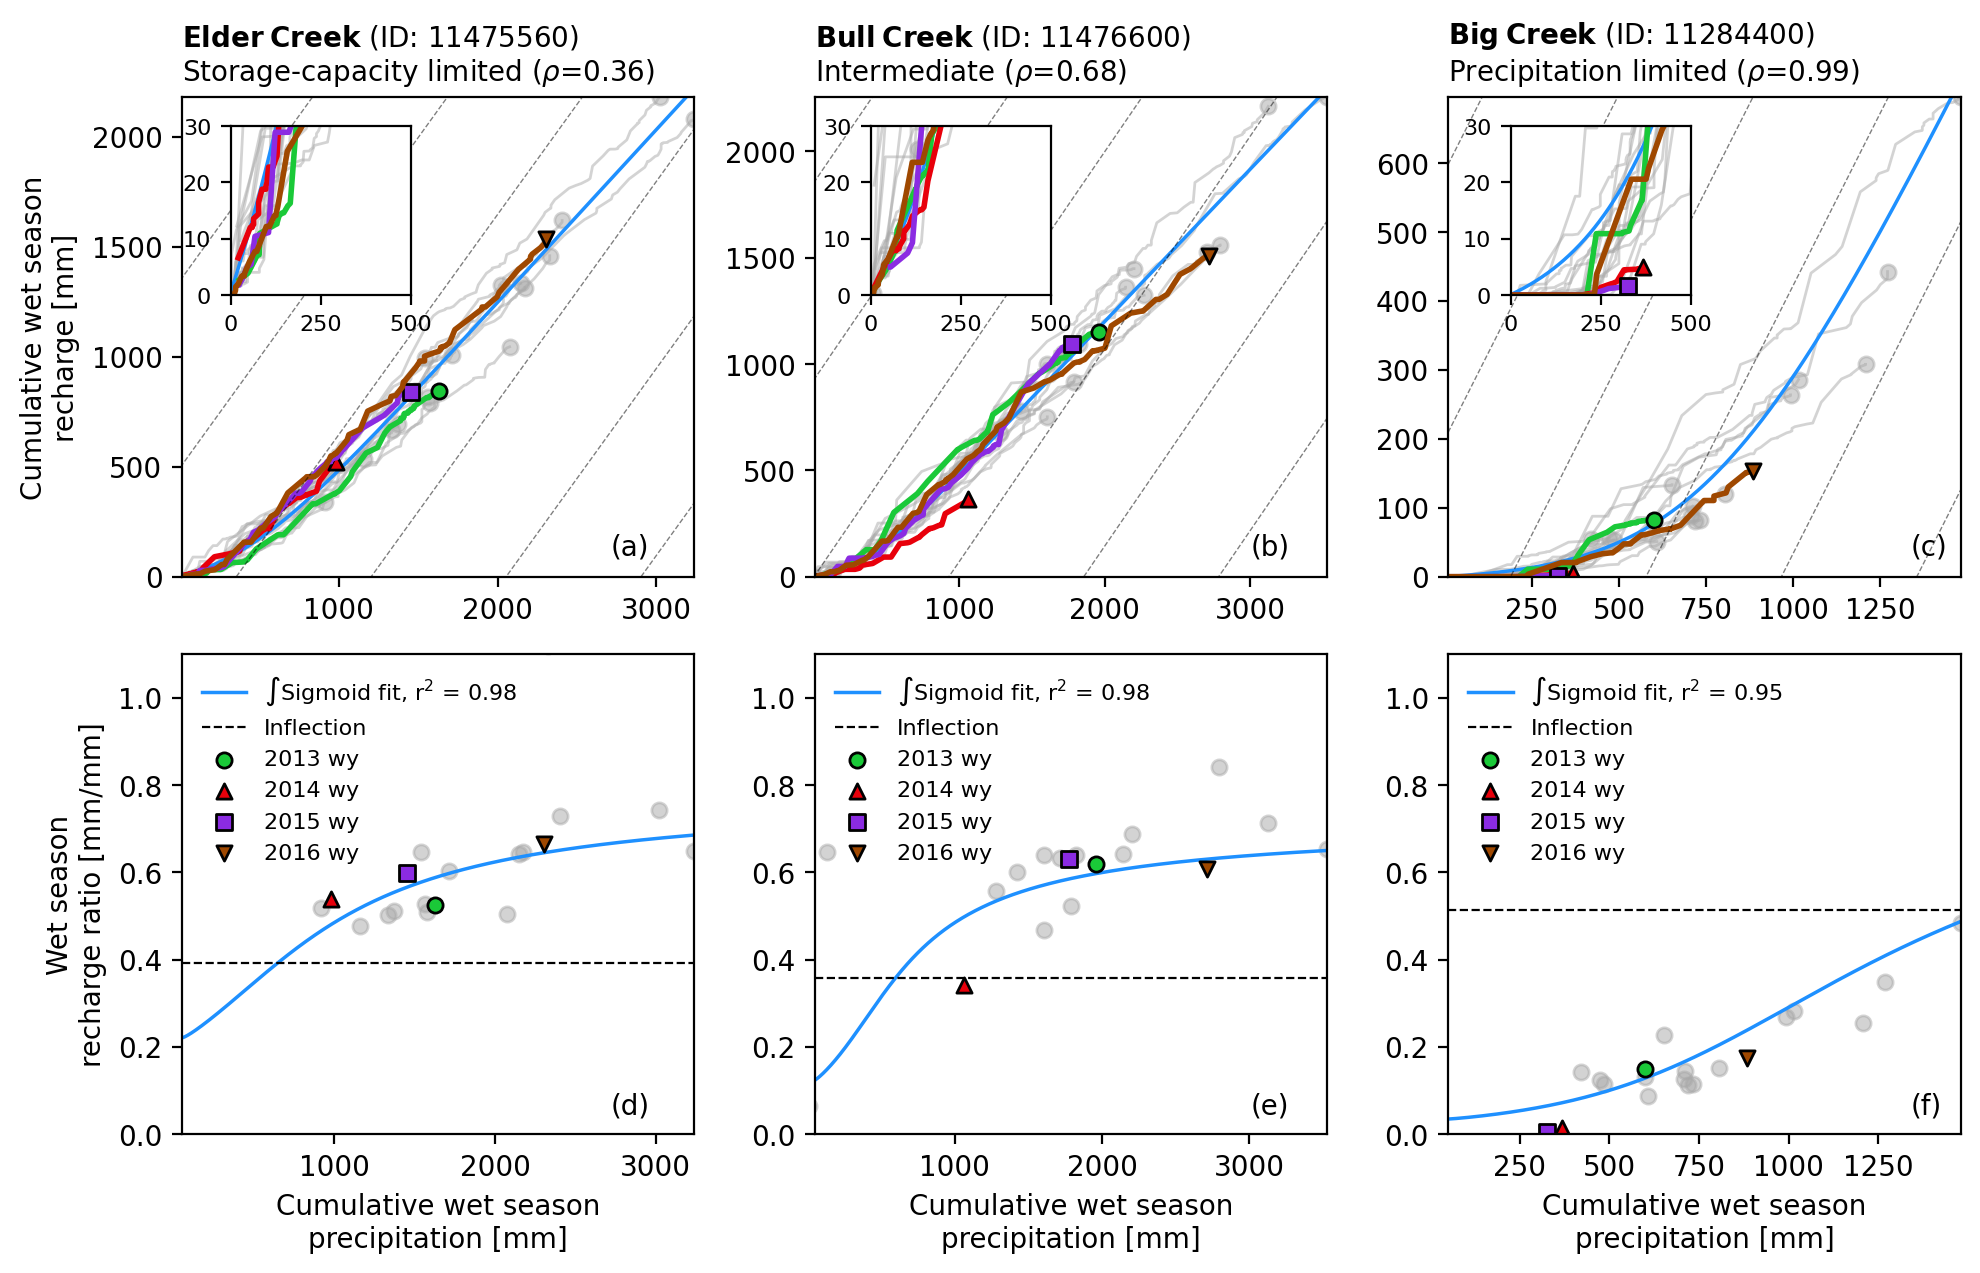

In [7]:
# Supress numpy "invalid value encountered in log" runtime warning
warnings.simplefilter('ignore', RuntimeWarning)

# Create plotting space
fig,axs = plt.subplots(2,3,figsize=(10,6.5))

# Cumulative recharge vs. cumulative precipitation
for gage, ax in zip(gages,[axs[0,0],axs[0,1],axs[0,2]]):
  recharge_plot(df_gages,gage,ax=ax,legend=False,highlight_wys=[2013,2014,2015,2016])
  ax.set_xlim(left=10)
  ax.set_xlabel("")

# Inset plots
Elder_inset = fig.add_axes([0.12, 0.76, 0.09, 0.13])
Bull_inset = fig.add_axes([0.44, 0.76, 0.09, 0.13])
Big_inset = fig.add_axes([0.76, 0.76, 0.09, 0.13])
for gage, ax in zip(gages,[Elder_inset,Bull_inset,Big_inset]):
  recharge_plot(df_gages,gage,ax=ax,legend=False,inset=True,highlight_wys=[2013,2014,2015,2016])
  ax.tick_params(axis='both', which='major', labelsize=8)
  ax.set(ylim=[0,30],xlim=[0,500])

# Recharge Ratio
Elder_ratio = axs[1,0]
Bull_ratio = axs[1,1]
Big_ratio = axs[1,2]
for gage, ax in zip(gages,[Elder_ratio,Bull_ratio,Big_ratio]):
  recharge_plot(df_gages,gage,ax=ax,ratio=True,legend=True,highlight_wys=[2013,2014,2015,2016])
Elder_ratio.set(ylim=[0,1.1])
Bull_ratio.set(ylim=[0,1.1],ylabel="")
Big_ratio.set(ylim=[0,1.1],ylabel="")

# Figure appearance, layout
fig.text(0.31,0.56,"(a)")
fig.text(0.63,0.56,"(b)")
fig.text(0.96,0.56,"(c)")
fig.text(0.31,0.13,"(d)")
fig.text(0.63,0.13,"(e)")
fig.text(0.96,0.13,"(f)")
axs[0,1].set_ylabel("")
axs[0,2].set_ylabel("")
axs[0,0].set_title(r"$\bf{Elder\hspace{0.25}Creek}$"+" (ID: 11475560)\nStorage-capacity limited "+r"($\rho$=0.36)", loc='left', fontsize=10)
axs[0,1].set_title(r"$\bf{Bull\hspace{0.25}Creek}$"+" (ID: 11476600)\nIntermediate "+r"($\rho$=0.68)", loc='left', fontsize=10)
axs[0,2].set_title(r"$\bf{Big\hspace{0.25}Creek}$"+" (ID: 11284400)\nPrecipitation limited "+r"($\rho$=0.99)", loc='left', fontsize=10)
fig.tight_layout()

#**2. Modified seasonal mass-balance at each catchment**

**Helper function.**

In [8]:
def first_rainfall(df):
  """Find the datetime of the first storm event occuring after the start
  of the precipitation time series.  Return DataFrame after first rainfall.

  Parameters
  ----------
  df : DataFrame with np.datetime64 index containing precipitation time series (column name = 'ppt') in mm.

  Returns
  ----------
  df : DataFrame containing data after first rainfall.
  """
  first_rain = df.loc[df['ppt']>=2].index[0]
  lag = pd.Timedelta(days=2)
  while first_rain <= df.index[0]+lag:
    df = df[first_rain+lag:]
    first_rain = df.loc[df['ppt']>=2].index[0]
  return df[first_rain:]

**$Q_{wy}$ vs. $P_{wy}$ and $P_{wy} - D_{\textrm{first rain}}$.**

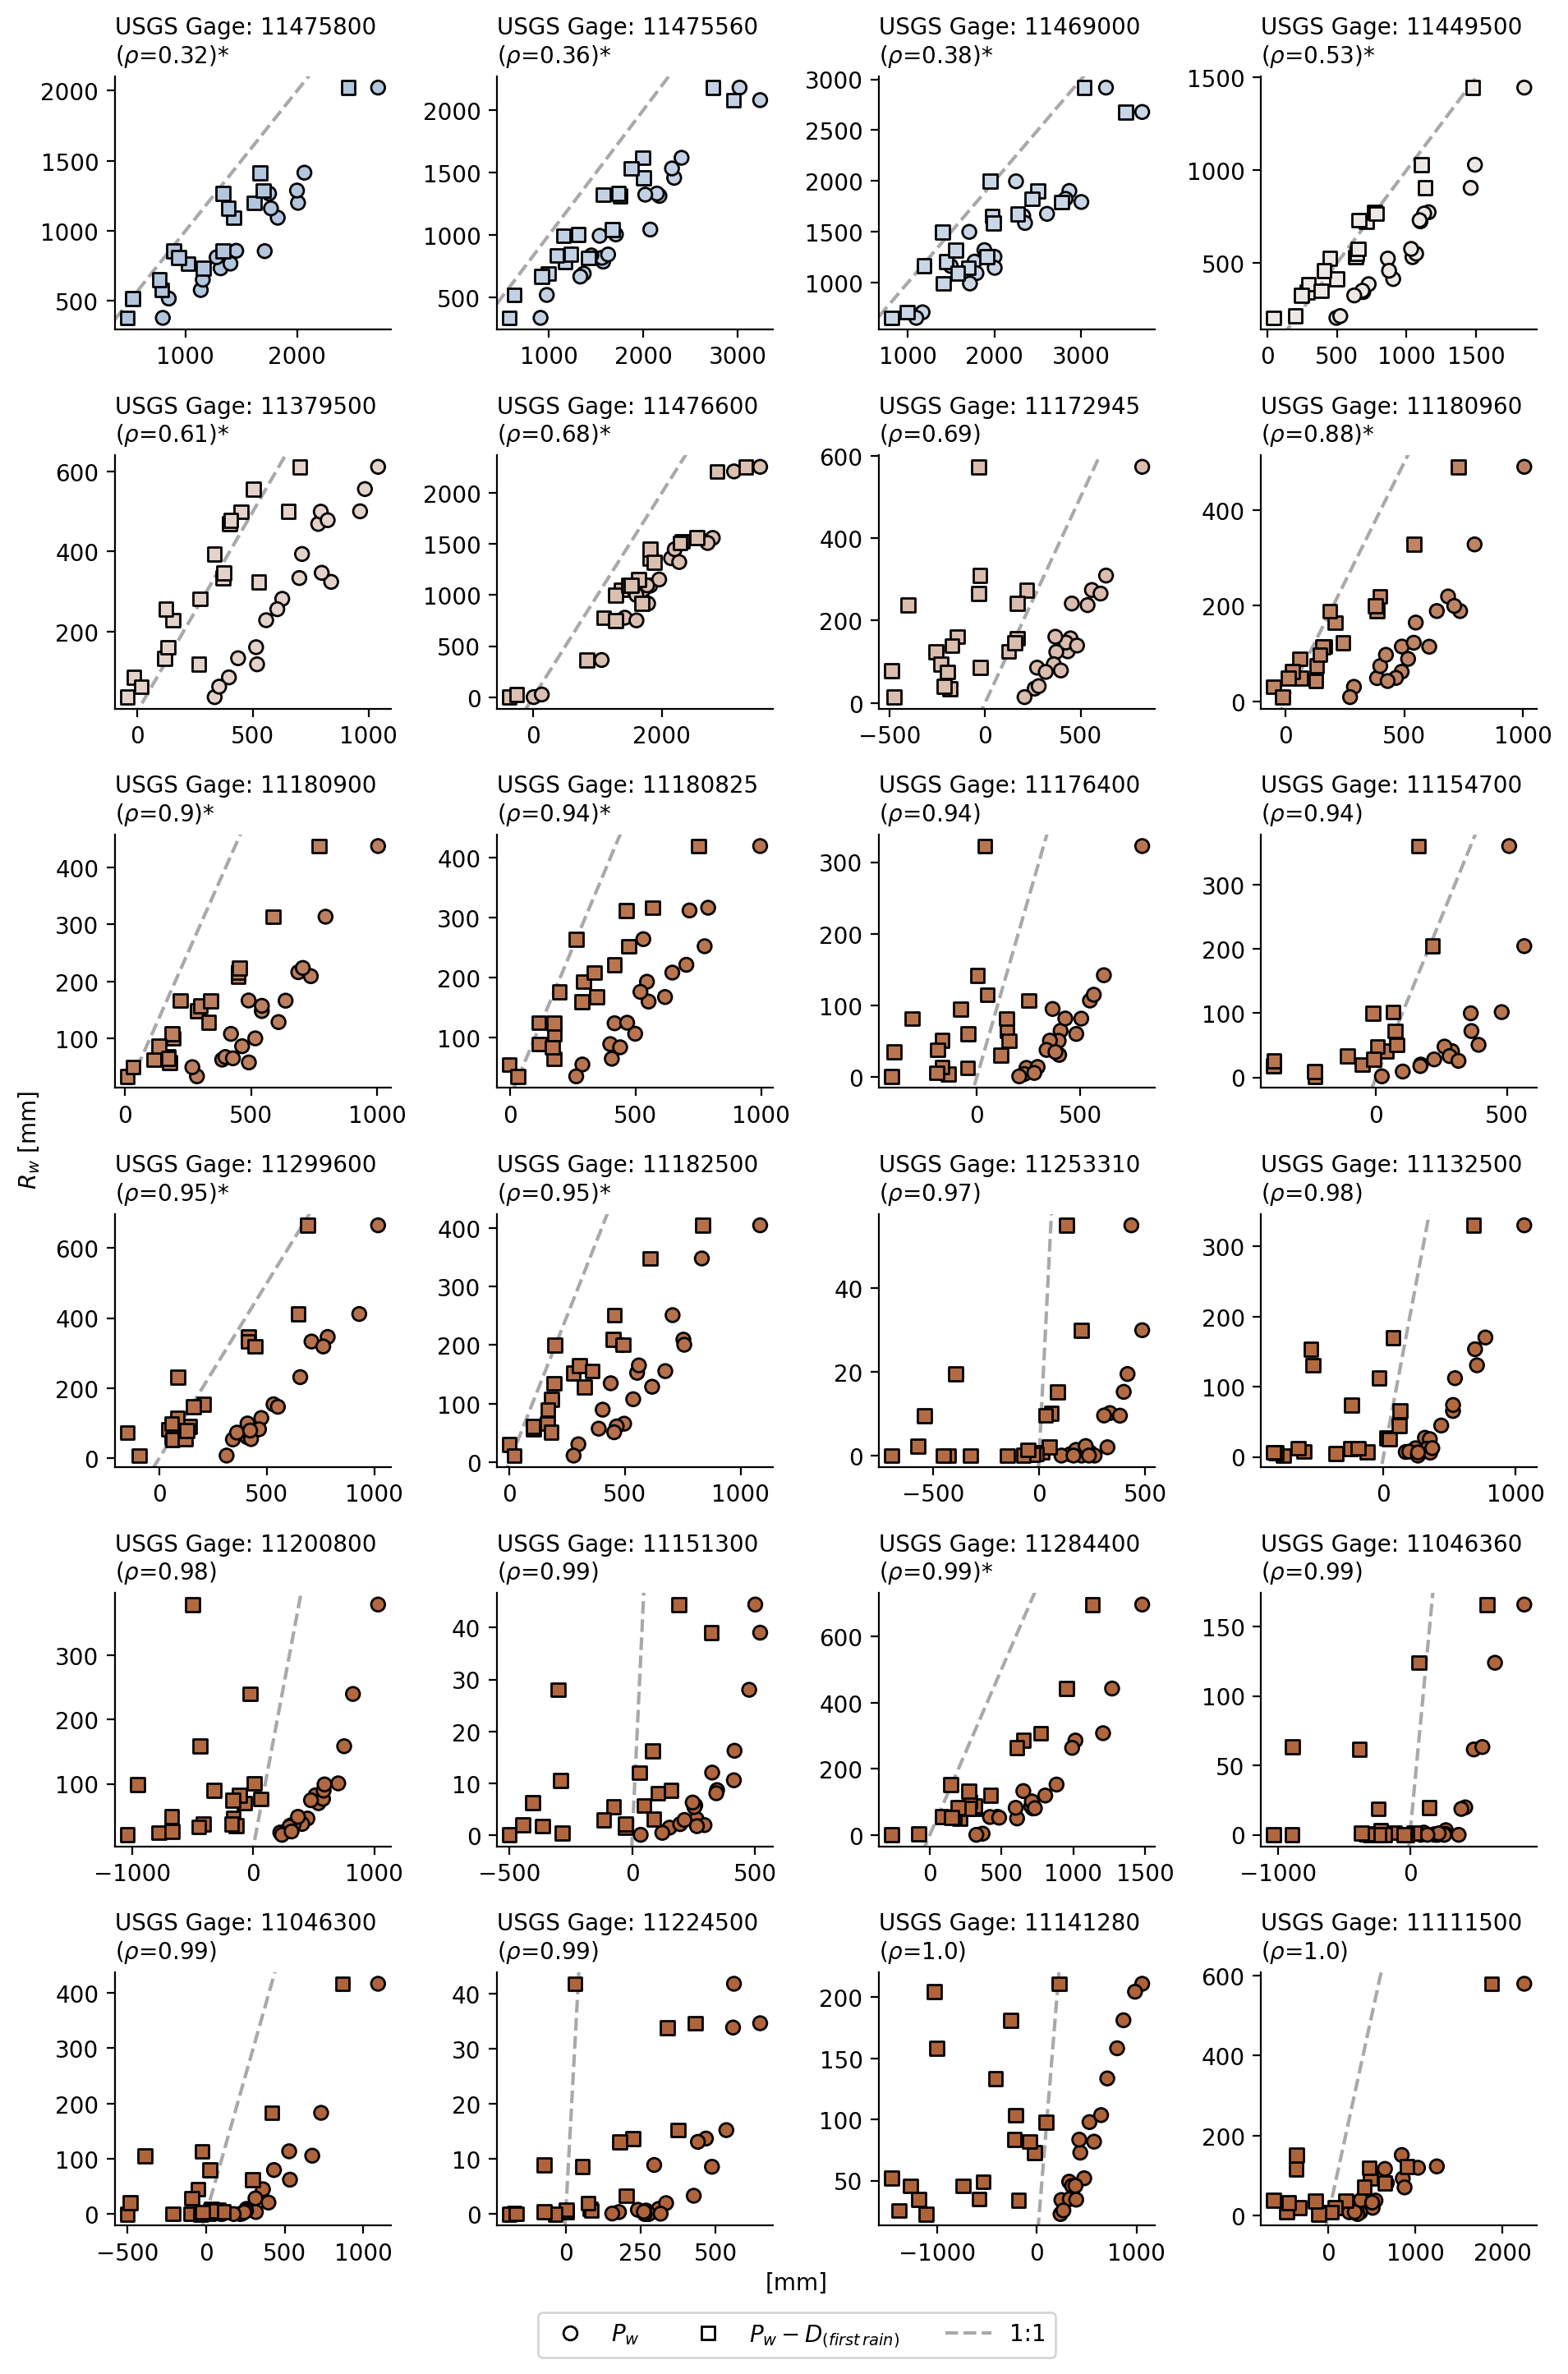

In [9]:
# Unique gage IDs in DataFrame
gage_list = df_attr.sort_values(by='Storage sensitivity to winter precipitation (rho)',ascending=True).index

# Plotting space
fig, axs = plt.subplots(6,4,figsize=(9.5,14))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Run through gages
analysis_gages = np.array([])
for gage, ax in zip(gage_list,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  # Identify winter hydrology, wateryears
  winter_months = [10,11,12,1,2,3]
  df_gage = df_gage[df_gage.index.month.isin(winter_months)]
  wateryears = df_gage.wateryear.unique()
  x1 = np.array([])
  x2 = np.array([])
  y = np.array([])
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = df.D.iloc[0]
    x1 = np.append(x1,df.ppt.sum())
    x2 = np.append(x2,df.ppt.sum()-df.D.iloc[0])
    y = np.append(y,df.rt.sum())
  ax.scatter(x1,y,c=[rho]*len(x1),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.scatter(x2,y,c=[rho]*len(x2),ec='k',marker='s',cmap=cmap,vmin=0,vmax=1)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Identify watersheds without a runaway deficit
  if len(x2[x2<0])<5:
    analysis_gages = np.append(analysis_gages,gage)
    title = title+"*"
  ax.set(xlabel=None,ylabel=None)
  ax.set_title(title,loc='left',fontsize=10)

# Label, legend, figure handling
fig.text(0.5, 0, "[mm]", ha='center')
fig.text(0, 0.5, r"$R_{w}$ [mm]", va='center', rotation='vertical')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='o',ls='',label=r"$P_{w}$"),
                   Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label=r"$P_{w}-D_{(first\/rain)}$"),
                   Line2D([0],[0],color='darkgray',ls='--',label="1:1")]
fig.legend(handles=legend_elements,loc='center',ncol=3,bbox_to_anchor=(0.5,-0.02))
fig.tight_layout()
sns.despine()

**Cumulative water year mass-balance.**

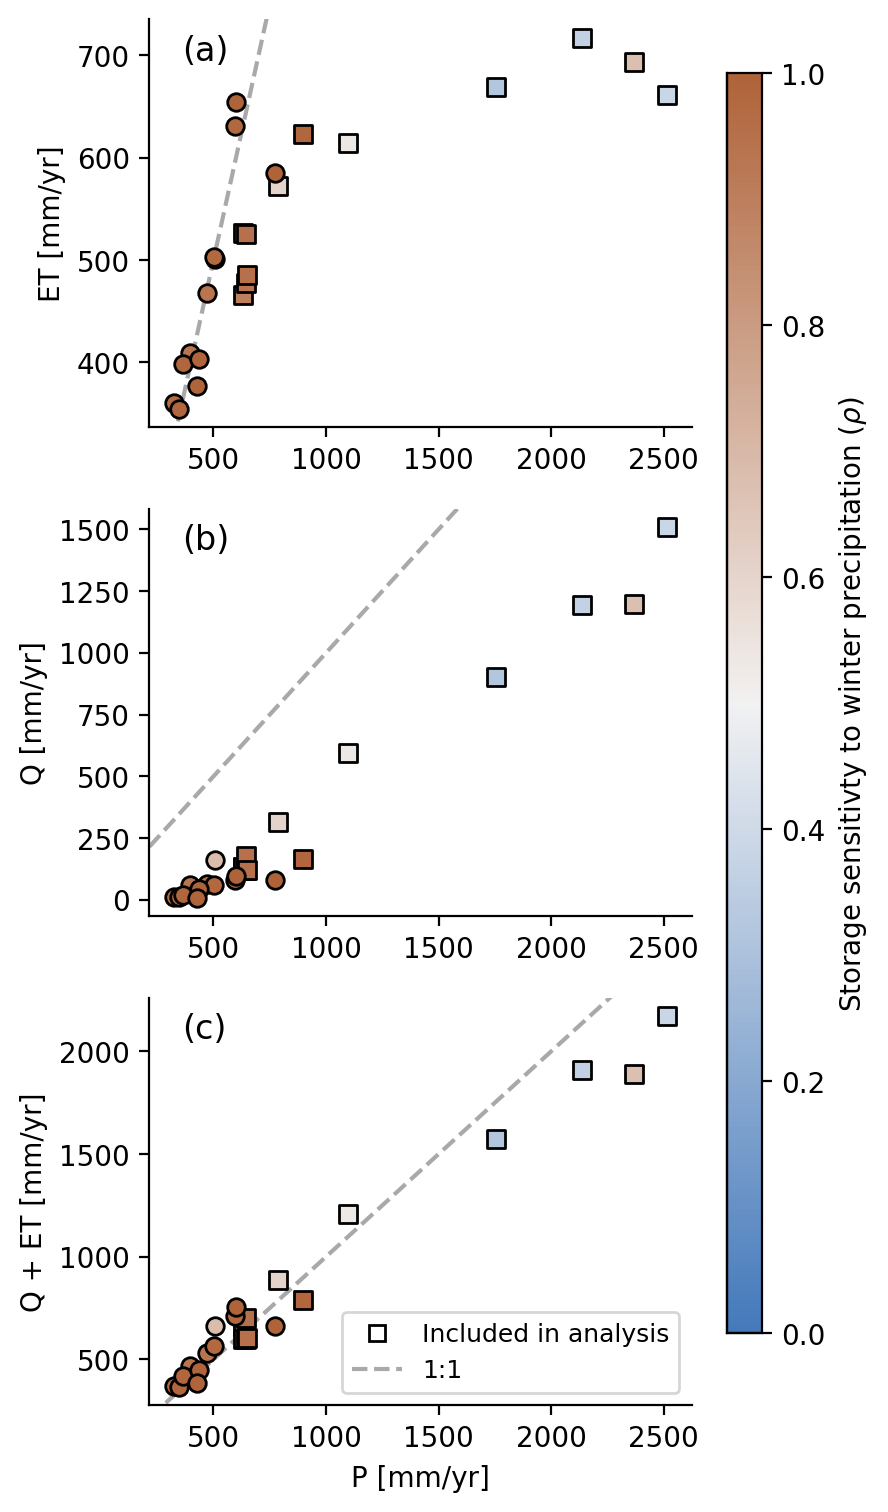

In [10]:
# Plotting space, color map
fig,axs = plt.subplots(3,1,figsize=(3.5,9))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# List of gages classified as storage-capcity limited (Hahm et al., 2022)
scl_gages = ['11475560','11475800','11469000','11449500','11379500','11476600']

# Sum timeseries of complete fluxes for each gage, append to array
ppt_sum = np.array([])
et_sum = np.array([])
q_sum = np.array([])
color = np.array([])
marker = np.array([])
for gage in gage_list:
  # Plotting color based on limitation
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  color = np.append(color,rho)
  # Marker based on whether gage is included in analysis
  marker = np.append(marker,'s') if gage in analysis_gages else np.append(marker,'o')
  # Filter by gage
  df_gage_sum = df_gages.filter(regex=".*%s"%gage).dropna().sum()
  num_years = len(df_gages.filter(regex=".*%s"%gage).dropna())/365
  ppt_sum = np.append(ppt_sum,df_gage_sum['ppt_'+gage]/num_years)
  et_sum = np.append(et_sum,df_gage_sum['et_'+gage]/num_years)
  q_sum = np.append(q_sum,df_gage_sum['q_'+gage]/num_years)

# Plot raw data
kwargs = {'s':40,'ec':'k'}
for i in range(len(gage_list)):
  data = axs[0].scatter(ppt_sum[i], et_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. ET
  axs[1].scatter(ppt_sum[i], q_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. Q
  axs[2].scatter(ppt_sum[i], et_sum[i]+q_sum[i], c=color[i], marker=marker[i], cmap=cmap, vmin=0, vmax=1, **kwargs) # P vs. Q + ET

# 1:1 line
for ax in axs:
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Colorbar
cbar_ax = fig.add_axes([0.95,0.15,0.05,0.7])
axcb = fig.colorbar(data,cax=cbar_ax)
axcb.set_label(r'Storage sensitivty to winter precipitation ($\rho$)')
data.set_clim(0,1)

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label="Included in analysis"),
                  #  Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='o',ls='',label="Extracted Basin"),
                   Line2D([0],[0],color='darkgray',ls='--',label="1:1")]
axs[2].legend(handles=legend_elements,loc='lower right',fontsize=9)

# Text
axs[0].annotate('(a)', (.06,.9), xycoords= 'axes fraction', fontsize=12)
axs[1].annotate('(b)', (.06,.9), xycoords= 'axes fraction', fontsize=12)
axs[2].annotate('(c)', (.06,.9), xycoords= 'axes fraction', fontsize=12)

# Axis handling, despine
axs[0].set(ylabel="ET [mm/yr]")
axs[1].set(ylabel="Q [mm/yr]")
axs[2].set(xlabel="P [mm/yr]",ylabel="Q + ET [mm/yr]")
sns.despine()

**Plot $Q_{wy}$ vs. $P_{wy}$ and $P_{wy} - D_{\textrm{first rain}}$ for those catchments wihtout a runaway deficit.**  

Define catchments with a runaway deficit where ($P_{wy} - D_{\textrm{first rain}}) <0$ for at least 5 years.

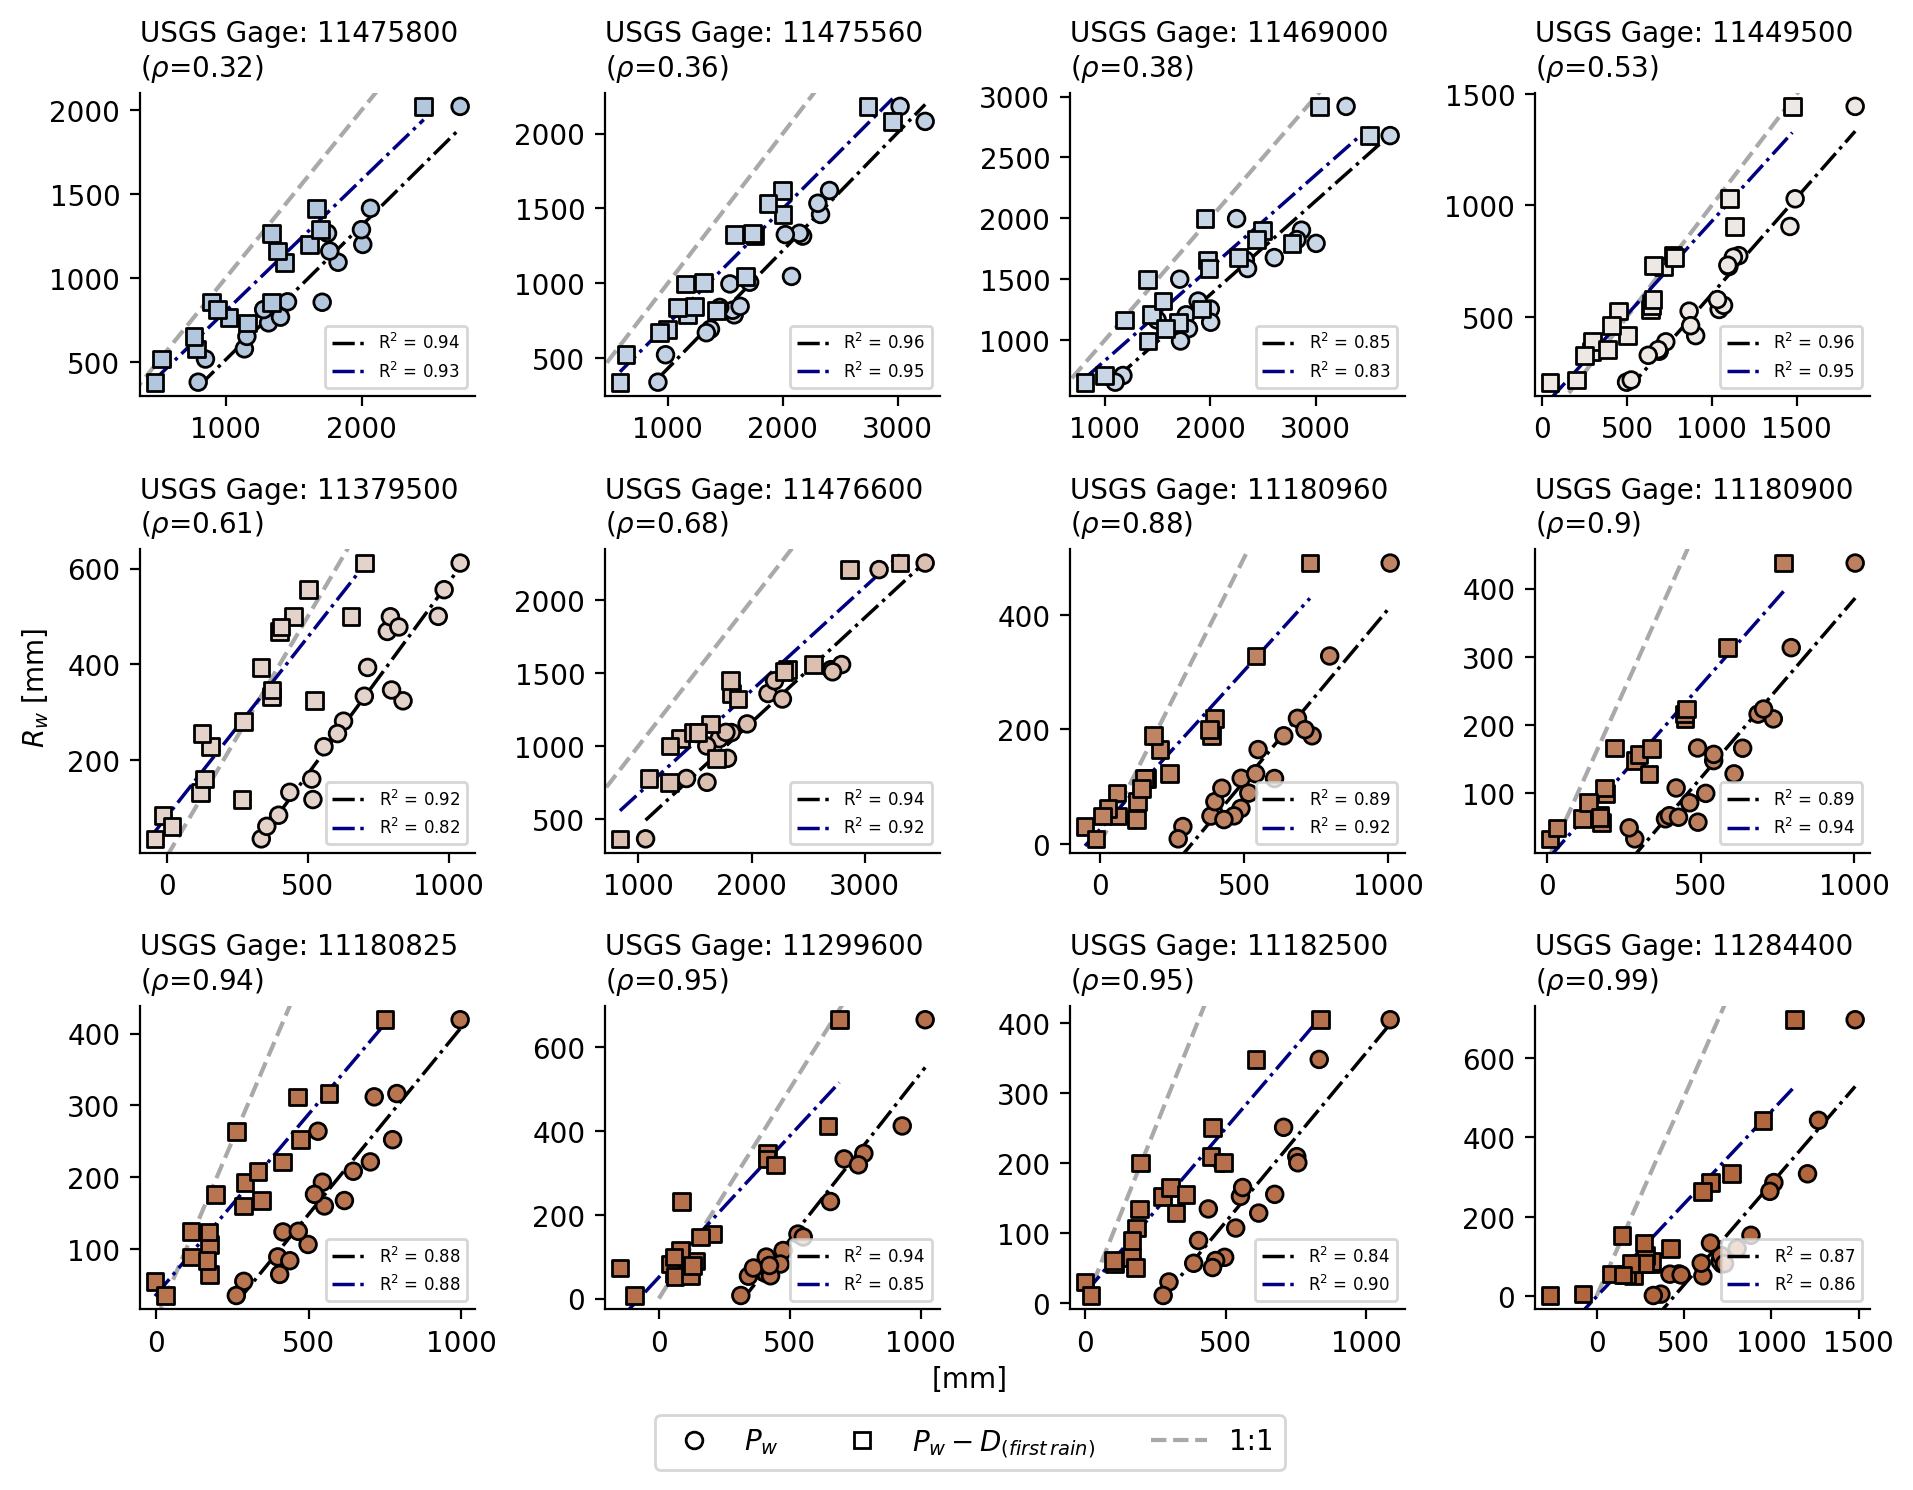

In [11]:
# Plotting space
fig, axs = plt.subplots(3,4,figsize=(9.5,7))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Cumulative recharge vs. cumulative precipitation
for gage, ax in zip(analysis_gages,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  # Identify winter hydrology, wateryears
  winter_months = [10,11,12,1,2,3]
  df_gage = df_gage[df_gage.index.month.isin(winter_months)]
  wateryears = df_gage.wateryear.unique()
  x1 = np.array([])
  x2 = np.array([])
  deficit = np.array([])
  y = np.array([])
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = np.append(deficit,df.D.iloc[0])
    # Check wateryear length
    if len(df)<100: continue
    # Append
    x1 = np.append(x1,df.ppt.sum())
    x2 = np.append(x2,df.ppt.sum()-df.D.iloc[0])
    y = np.append(y,df.rt.sum())
  ax.scatter(x1,y,c=[rho]*len(x1),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.scatter(x2,y,c=[rho]*len(x2),ec='k',marker='s',cmap=cmap,vmin=0,vmax=1)
  ax.set_title(title,loc='left',fontsize=10)

  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([0,xmax],[0,xmax], c='darkgray', ls='--', zorder=-2)

  # 1:1 line R vs. P
  p = np.polyfit(x1,y,deg=1)
  coefficient_of_determination = r2_score(y,p[1]+p[0]*x1)
  xfit = np.linspace(min(x1),max(x1),50)
  yfit = p[1]+p[0]*xfit
  ax.plot(xfit, yfit, label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, c='k', ls='-.', lw=1.25, zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

  # 1:1 line R vs P-D
  p = np.polyfit(x2,y,deg=1)
  coefficient_of_determination = r2_score(y,p[1]+p[0]*x2)
  xfit = np.linspace(min(x2),max(x2),50)
  yfit = p[1]+p[0]*xfit
  ax.plot(xfit, yfit, label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, c='navy', ls='-.', lw=1.25, zorder=-2)
  ax.legend(loc='lower right',fontsize=6)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Label, legend, figure handling
fig.text(0.5, 0, "[mm]", ha='center')
fig.text(0, 0.5, r"$R_w$ [mm]", va='center', rotation='vertical')
legend_elements = [Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='o',ls='',label=r"$P_w$"),
                   Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label=r"$P_w-D_{(first\/rain)}$"),
                   Line2D([0],[0],color='darkgray',ls='--',label="1:1")]
fig.legend(handles=legend_elements,loc='center',ncol=3,bbox_to_anchor=(0.5,-0.04))
fig.tight_layout()
sns.despine()

**Previous plot, colored by deficit**

<ipython-input-12-15f9a7ca1058>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


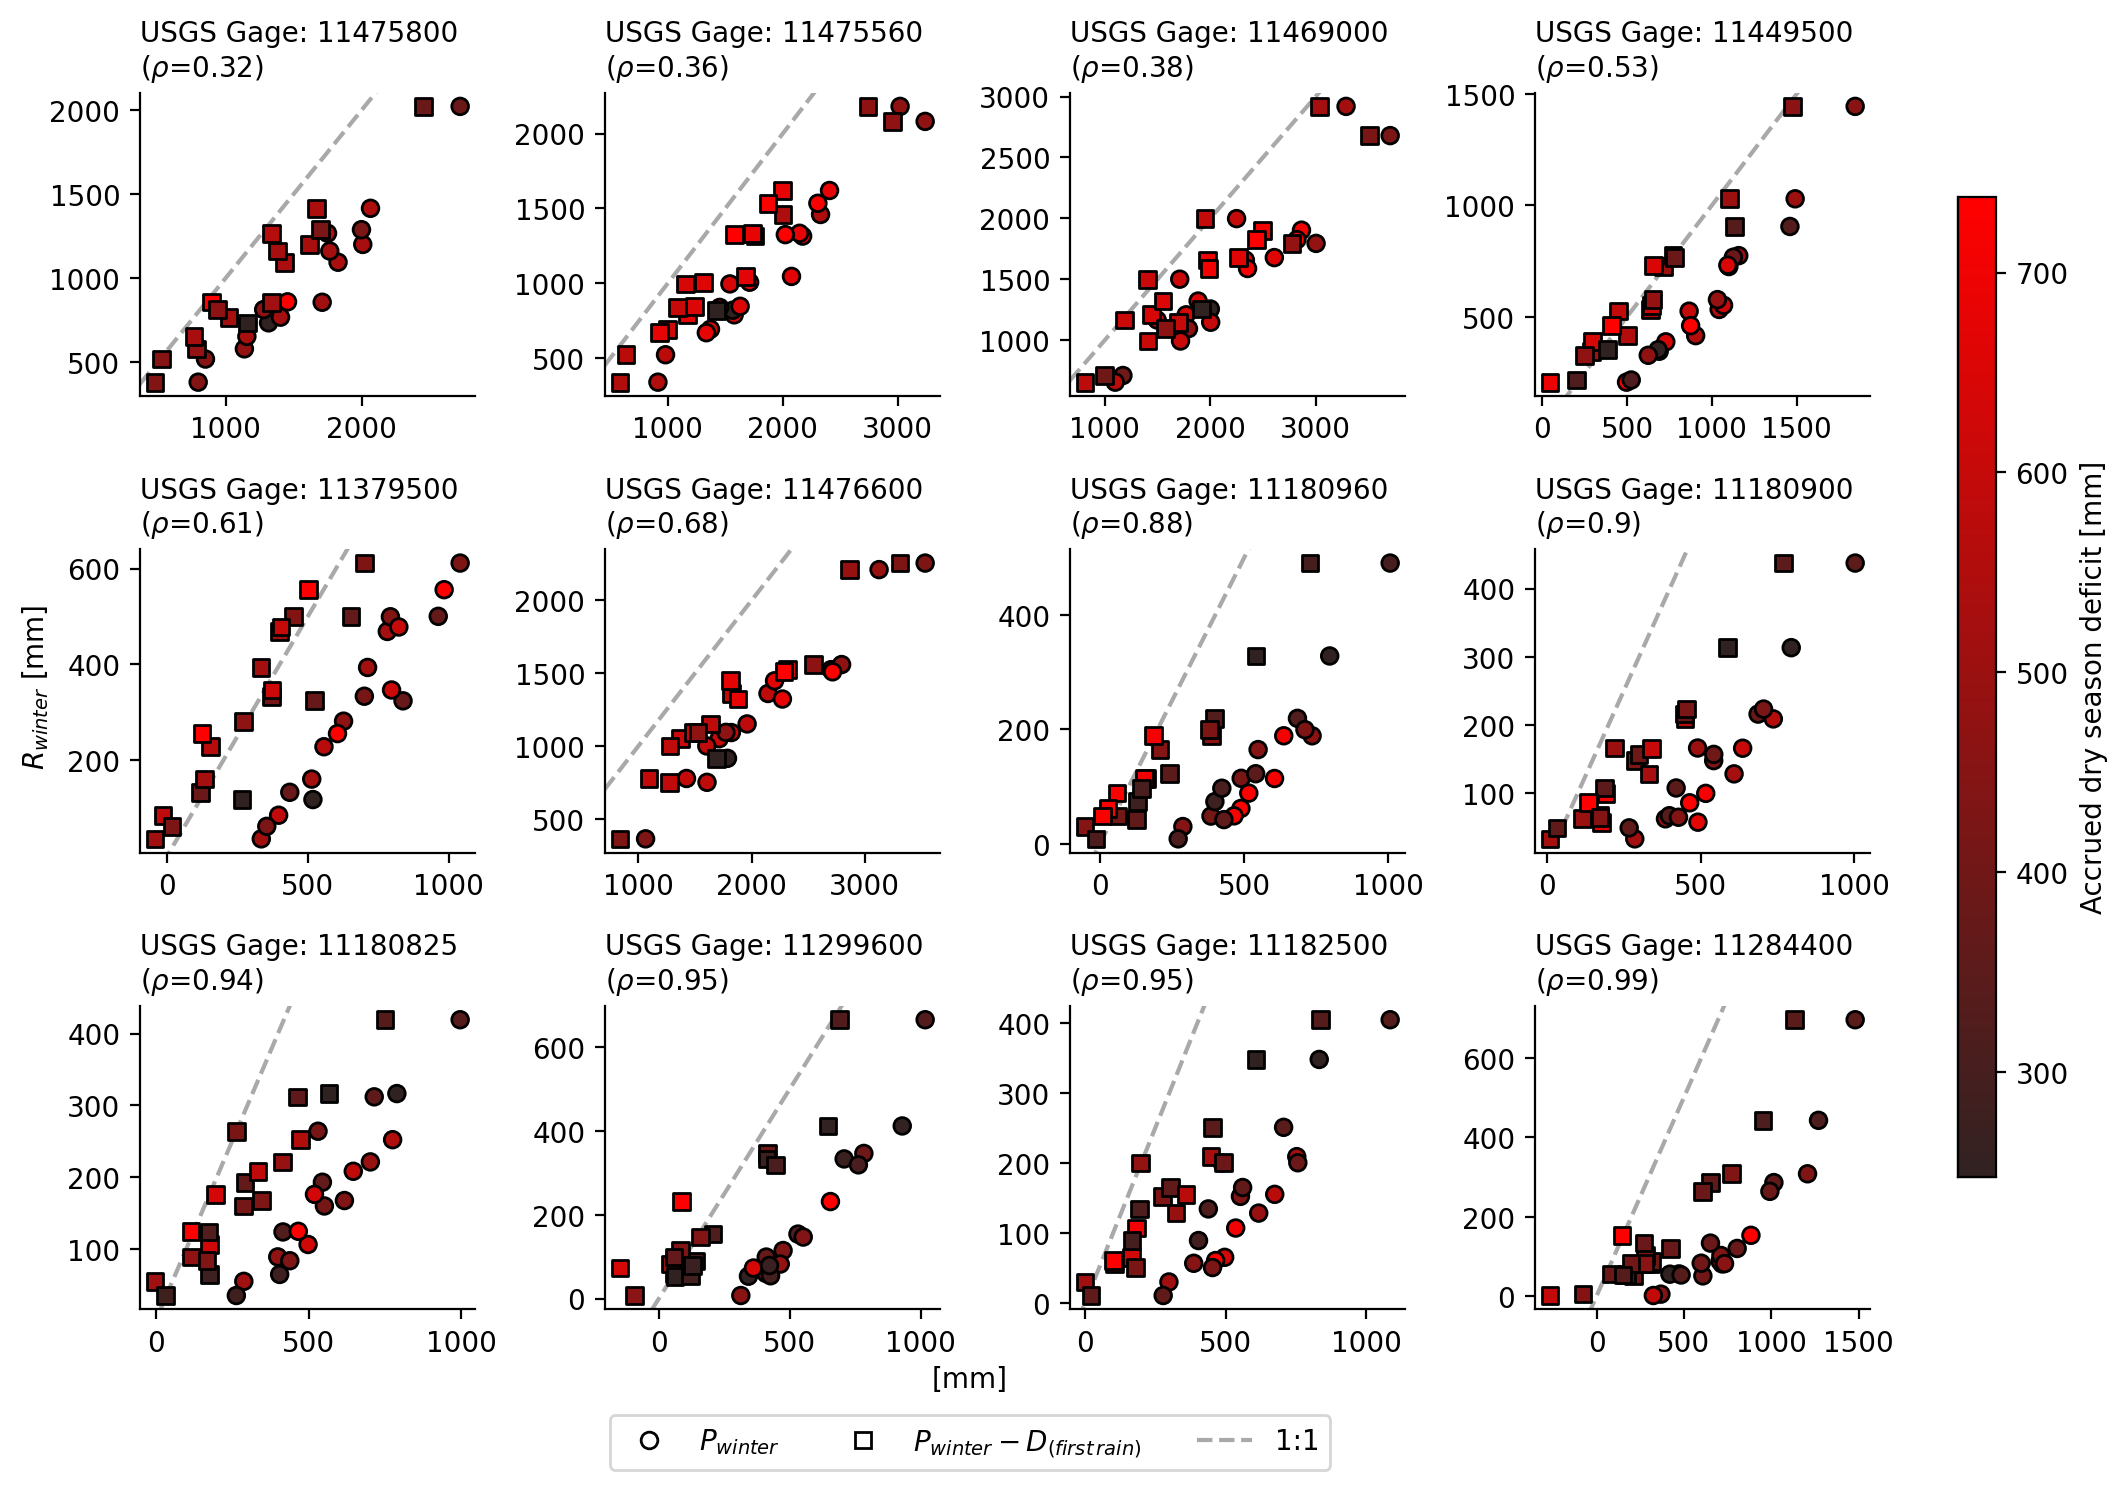

In [12]:
# Plotting space
fig, axs = plt.subplots(3,4,figsize=(9.5,7))
# cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)
cmap = sns.dark_palette("red", as_cmap=True) # for deficit

# Cumulative recharge vs. cumulative precipitation
for gage, ax in zip(analysis_gages,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  # Identify winter hydrology, wateryears
  winter_months = [10,11,12,1,2,3]
  df_gage = df_gage[df_gage.index.month.isin(winter_months)]
  wateryears = df_gage.wateryear.unique()
  x1 = np.array([])
  x2 = np.array([])
  y = np.array([])
  c_temp1 = np.array([])
  c_temp2 = np.array([])
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = df.D.iloc[0]
    # Check wateryear length
    if len(df)<100: continue
    # Append
    x1 = np.append(x1,df.ppt.sum())
    x2 = np.append(x2,df.ppt.sum()-df.D.iloc[0])
    y = np.append(y,df.rt.sum())
    c_temp1 =np.append(c_temp1,deficit)
    c_temp2 =np.append(c_temp2,deficit)
  vmin = min(min(c_temp1),min(c_temp1))
  vmax = max(max(c_temp1),max(c_temp2))
  data = ax.scatter(x1,y,c=c_temp1,ec='k',marker='o',cmap=cmap,vmin=vmin,vmax=vmax) #c=[rho]*len(x1)
  ax.scatter(x2,y,c=c_temp2,ec='k',marker='s',cmap=cmap,vmin=vmin,vmax=vmax) #c=[rho]*len(x2)
  ax.set_title(title,loc='left',fontsize=10)

  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Colorbar
cbar_ax = fig.add_axes([1.02,0.15,0.02,0.7])
axcb = fig.colorbar(data,cax=cbar_ax)
axcb.set_label(r'Accrued dry season deficit [mm]')
data.set_clim(vmin,vmax)

# Label, legend, figure handling
fig.text(0.5, 0, "[mm]", ha='center')
fig.text(0, 0.5, r"$R_{winter}$ [mm]", va='center', rotation='vertical')
legend_elements = [Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='o',ls='',label=r"$P_{winter}$"),
                   Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label=r"$P_{winter}-D_{(first\/rain)}$"),
                   Line2D([0],[0],color='darkgray',ls='--',label="1:1")]
fig.legend(handles=legend_elements,loc='center',ncol=3,bbox_to_anchor=(0.5,-0.04))
fig.tight_layout()
sns.despine()

#**3. Recharge in the first 500 mm of precipitation, moderated by deficit**

Plot the cumulative recharge generated by the first 500 mm of precipitation vs. the maximum deficit at the start of the water year.  Fit a linear regression to those catchments with at least 5 wateryears where the cumulative precipitation exceeds 500 mm.

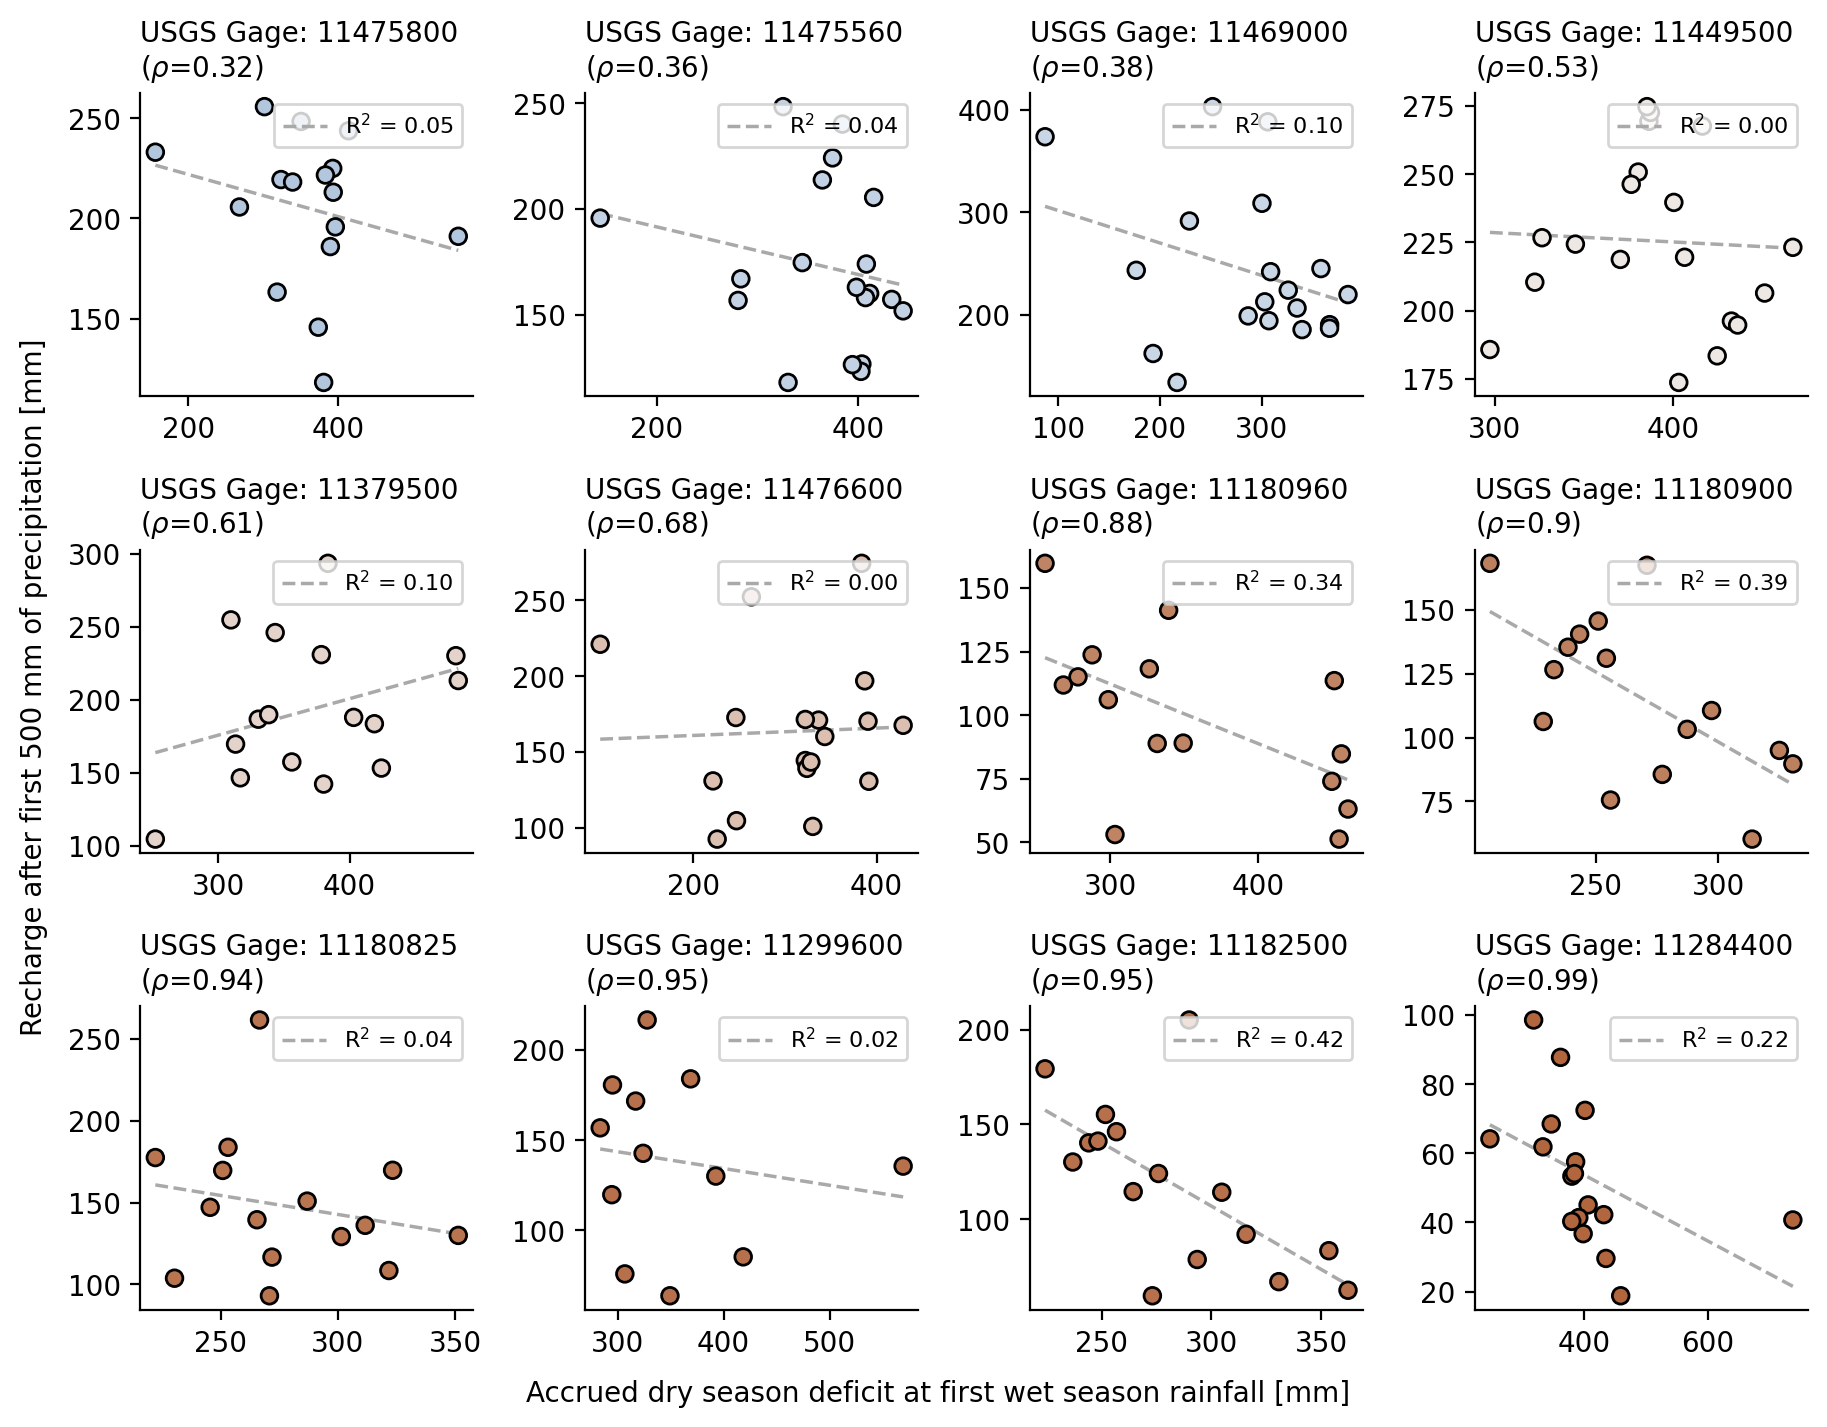

In [14]:
# Plotting space
fig, axs = plt.subplots(3,4,figsize=(9,7))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Plot cumulative recharge v.s. precipitation for each catchment
for gage, ax in zip(analysis_gages,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  # Define gage data
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  wateryears = df_gage.wateryear.unique()

  # Mean annual cumulative precipitation
  mean_annual_ppt = np.nanmean(df_gage.groupby('wateryear').ppt.cumsum().mean())
  threshold = 500 #(mm)
  xdata = np.array([])
  ydata = np.array([])
  n=0
  for wateryear in wateryears:
    # Skip first water year (allow deficit to accumulate), do not exceed 2020 water year (end of data)
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    deficit = df.D.iloc[0]
    # Recharge up to threshold of cumulative precipitation
    threshold_ppt = df.loc[df.ppt.cumsum()>=threshold].index
    if len(threshold_ppt)>0:
      df = df[df.ppt.cumsum()<=threshold]
      n+=1
    else: continue
    xdata = np.append(xdata,deficit)
    ydata = np.append(ydata,df.rt.cumsum().values[-1])
  ax.scatter(xdata,ydata,c=[rho]*len(xdata),ec='k',marker='o',cmap=cmap,vmin=0,vmax=1)
  ax.set_title(title,loc='left',fontsize=10)

  # Fit all wateryears with linear regression & plot
  if n>=5:
    p = np.polyfit(xdata,ydata,deg=1)
    coefficient_of_determination = r2_score(ydata,p[1]+p[0]*xdata)
    xfit = np.linspace(min(xdata),max(xdata),50)
    yfit = p[1]+p[0]*xfit
    ax.plot(xfit, yfit, label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, c='darkgray', ls='--', lw=1.25, zorder=-2)
    ax.legend(loc='upper right',fontsize=8)

# Label handling
fig.text(0.5, -0.01, 'Accrued dry season deficit at first wet season rainfall [mm]', ha='center')
fig.text(-0.01, 0.5, 'Recharge after first 500 mm of precipitation [mm]', va='center', rotation='vertical')

# Figure appearance
fig.tight_layout()
sns.despine()

#**4. Storm-event analysis**

**Show method of identifying storm events.**

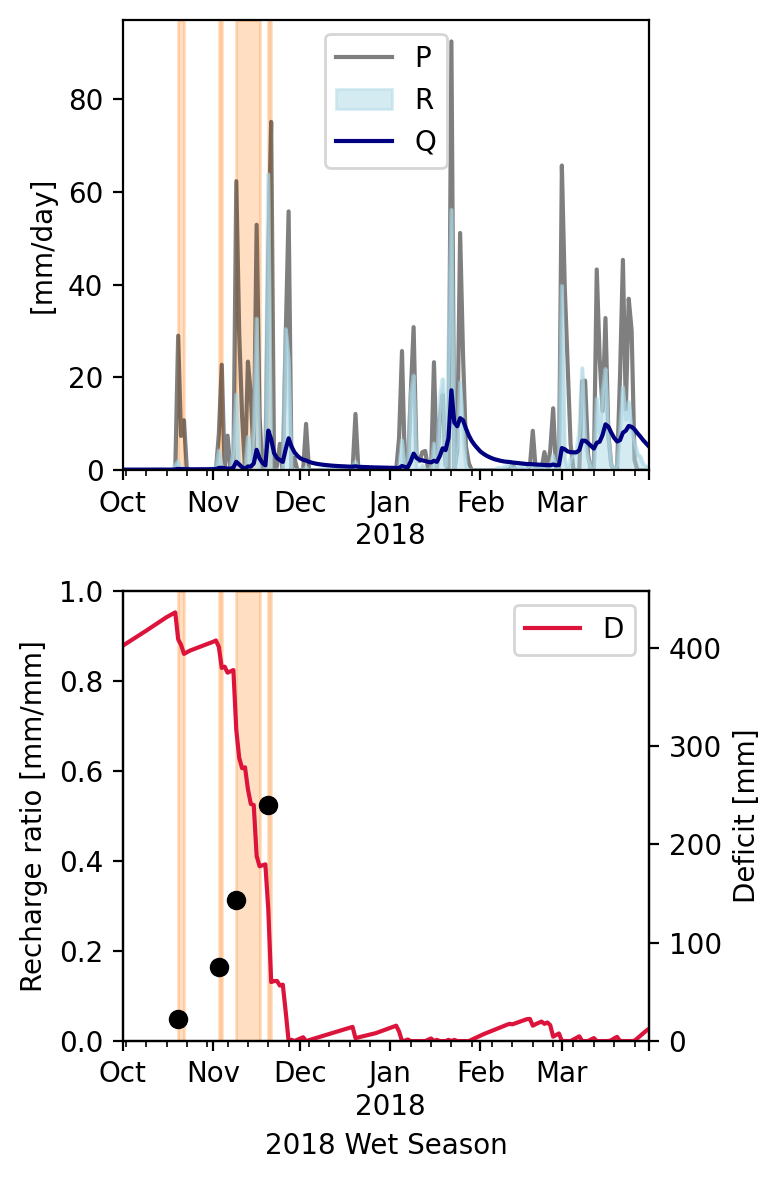

In [15]:
# Define gage, wateryear
gage = '11475560'
wateryear = 2018

# Plotting space
fig, axs = plt.subplots(2,1,figsize=(4,6))

# Define gage data
df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']])
df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
df_gage.set_index('date', inplace=True)
df_gage.index = pd.to_datetime(df_gage.index)

# Identify winter hydrology, water year
winter_months = [10,11,12,1,2,3]
df_winter = df_gage[df_gage.index.month.isin(winter_months)]
df_wy = df_winter[df_winter['wateryear']==wateryear]

# Plot winter discharge, precipitation, recharge
df_wy.plot(y='ppt', label='P', color='k', alpha=0.5, ax=axs[0], zorder=-2)
df_wy.plot(y='rt', label='R', kind='area', color='lightblue', alpha=0.5, ax=axs[0], zorder=-1)
df_wy.plot(y='q', label='Q', color='navy', ax=axs[0], zorder=0)

# Plot deficit
twinx = axs[1].axes.twinx()
df_wy.plot(y='D', label='D', color='crimson', ax=twinx, zorder=0)
twinx.set_ylim(bottom=0)

# Storm events occuring up to the deficit being reset
deficit_reset = df_wy.loc[df_wy.D<=0].index
if len(deficit_reset)!=0: df_wy = df_wy.loc[:deficit_reset[0]]
# df_wateryear_winter = df_wateryear # all storm events

# Identify rainfall events, removing the last rainfall event that reset the deficit
rainfall = df_wy.loc[df_wy.ppt>0].index
days_between_events = np.diff(rainfall)/np.timedelta64(1, 'D')
groups = np.split(rainfall, np.where(days_between_events>1.0)[0]+1)
rainfall_events = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]

# Calculate event recharge ratios
event_precip = np.array([df_wy.loc[event[0]:event[1]].cumsum().ppt.values[-1] for event in rainfall_events])
event_recharge = np.array([df_wy.loc[event[0]:event[1]].cumsum().rt.values[-1] for event in rainfall_events])
event_ratio = event_recharge/event_precip

# Exclude storm events with a storm volume less than 10 mm
idx = [i for i in range(len(rainfall_events)) if event_precip[i] >= 10]
event_precip = [event_precip[i] for i in idx]
event_ratio = [event_ratio[i] for i in idx]
rainfall_events = [rainfall_events[i] for i in idx]

# # Plot storm periods
start_of_storm = np.array([])
for event in rainfall_events:
  start_of_storm = np.append(start_of_storm,event[0])
  axs[0].axvspan(event[0],event[1],alpha=0.25,color='tab:orange',zorder=-4)
  axs[1].axvspan(event[0],event[1],alpha=0.25,color='tab:orange',zorder=-4)

# Plot
axs[1].scatter(start_of_storm,event_ratio,c='k',label='Event recharge ratio')

# Axis handling
axs[0].set(xlabel="",ylabel="[mm/day]")
axs[1].set(xlabel="%s Wet Season"%str(wateryear),ylabel="Recharge ratio [mm/mm]",ylim=[0,1])
twinx.set(ylabel="Deficit [mm]")

# Layout
fig.tight_layout()

**Define helper function.**

In [16]:
def storm_event_analysis(df_gages,gage,to_deficit=False):
  """Storm-event analysis of the interrelation between recharge, precipitation,
  and the root-zone storage deficit.

  Parameters
  ----------
  df_gages: DataFrame containing combined gage data for all study catchments
  gage: USGS gage ID corresponding to catchment (str)
  to_deficit (:obj:`bool`): When True, only plots events up to the deficit being reset
  ----------
  Returns
  ----------
  precip (:obj:`array`): Event precipitation (mm)
  recharge (:obj:`array`): Event recharge (mm)
  deficit (:obj:`array`): Deficit at the start of event (mm)
  length(:obj:`array`): Length of the storm event (days)
  year(:obj:array`): Water year in which the storm event occurred
  """
  df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']]).dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)

  # Identify water years containing >90% data
  wateryears = np.unique(df_gage.wateryear.values)
  wateryear_length = df_gage.dropna().groupby('wateryear').size()
  complete_wateryears = wateryear_length[wateryear_length>324].index.values

  # Arrays to store storm-event recharge ratio, deficit, and storm volume
  precip = np.array([])
  recharge = np.array([])
  discharge = np.array([])
  deficit = np.array([])
  length = np.array([])
  year = np.array([])

  # Identify storm events
  for wateryear in complete_wateryears:
    # Skip first water year, do not exceed 2020 water year
    if wateryear in [2001,2021]: continue
    # Start water year after first rainfall event occuring after Oct. 1st
    df_wy = first_rainfall(df_gage[df_gage['wateryear']==wateryear])
    # Storm events up to the deficit being reset
    deficit_reset = df_wy.loc[df_wy.D<=0].index
    if to_deficit==True and len(deficit_reset)!=0: df_wy = df_wy.loc[:deficit_reset[0]]
    # Identify storm periods, excluding the last storm event that occured as the deficit reset
    rainfall = df_wy.loc[df_wy.ppt>10].index # rainfall events with a total volume greater than 10 cm
    days_between_events = np.diff(rainfall)/np.timedelta64(1, 'D')
    groups = np.split(rainfall, np.where(days_between_events>1.0)[0]+1)
    rainfall_events = [[group[0],group[-1 if len(group)>1 else 0]] for group in groups[:-1]]
    # Check for 2-day gap between rainfall events
    inter_storm = np.array([(rainfall_events[i+1][0] - rainfall_events[i][1])/np.timedelta64(1,'D')-1 for i in range(len(rainfall_events)-1)])
    rainfall_events = [rainfall_events[0]]+[i for i,j in zip(rainfall_events[1:],inter_storm) if j>=2.0]
    # Calculate fluxes from event
    event_precip = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().ppt.values[-1] for rain_event in rainfall_events])
    event_recharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]+np.timedelta64(1,'D')].cumsum().rt.values[-1] for rain_event in rainfall_events]) # add day here to account for recharge lag
    event_discharge = np.array([df_wy.loc[rain_event[0]:rain_event[1]].cumsum().rt.values[-1] for rain_event in rainfall_events])
    event_length = np.array([(rain_event[1]-rain_event[0])/np.timedelta64(1,'D') for rain_event in rainfall_events])
    # Identify deficit at start of rainfall periods
    event_deficit = [df_wy.loc[rain_event[0]].D for rain_event in rainfall_events]
    # Append to DataFrame
    precip = np.append(precip,event_precip)
    recharge = np.append(recharge,event_recharge)
    discharge = np.append(recharge,event_discharge)
    deficit = np.append(deficit,event_deficit)
    length = np.append(length,event_length)
    year = np.append(year,[wateryear]*len(event_length))

  return precip, recharge, discharge, deficit, length+1, year

**Event precipitation vs. recharge.**

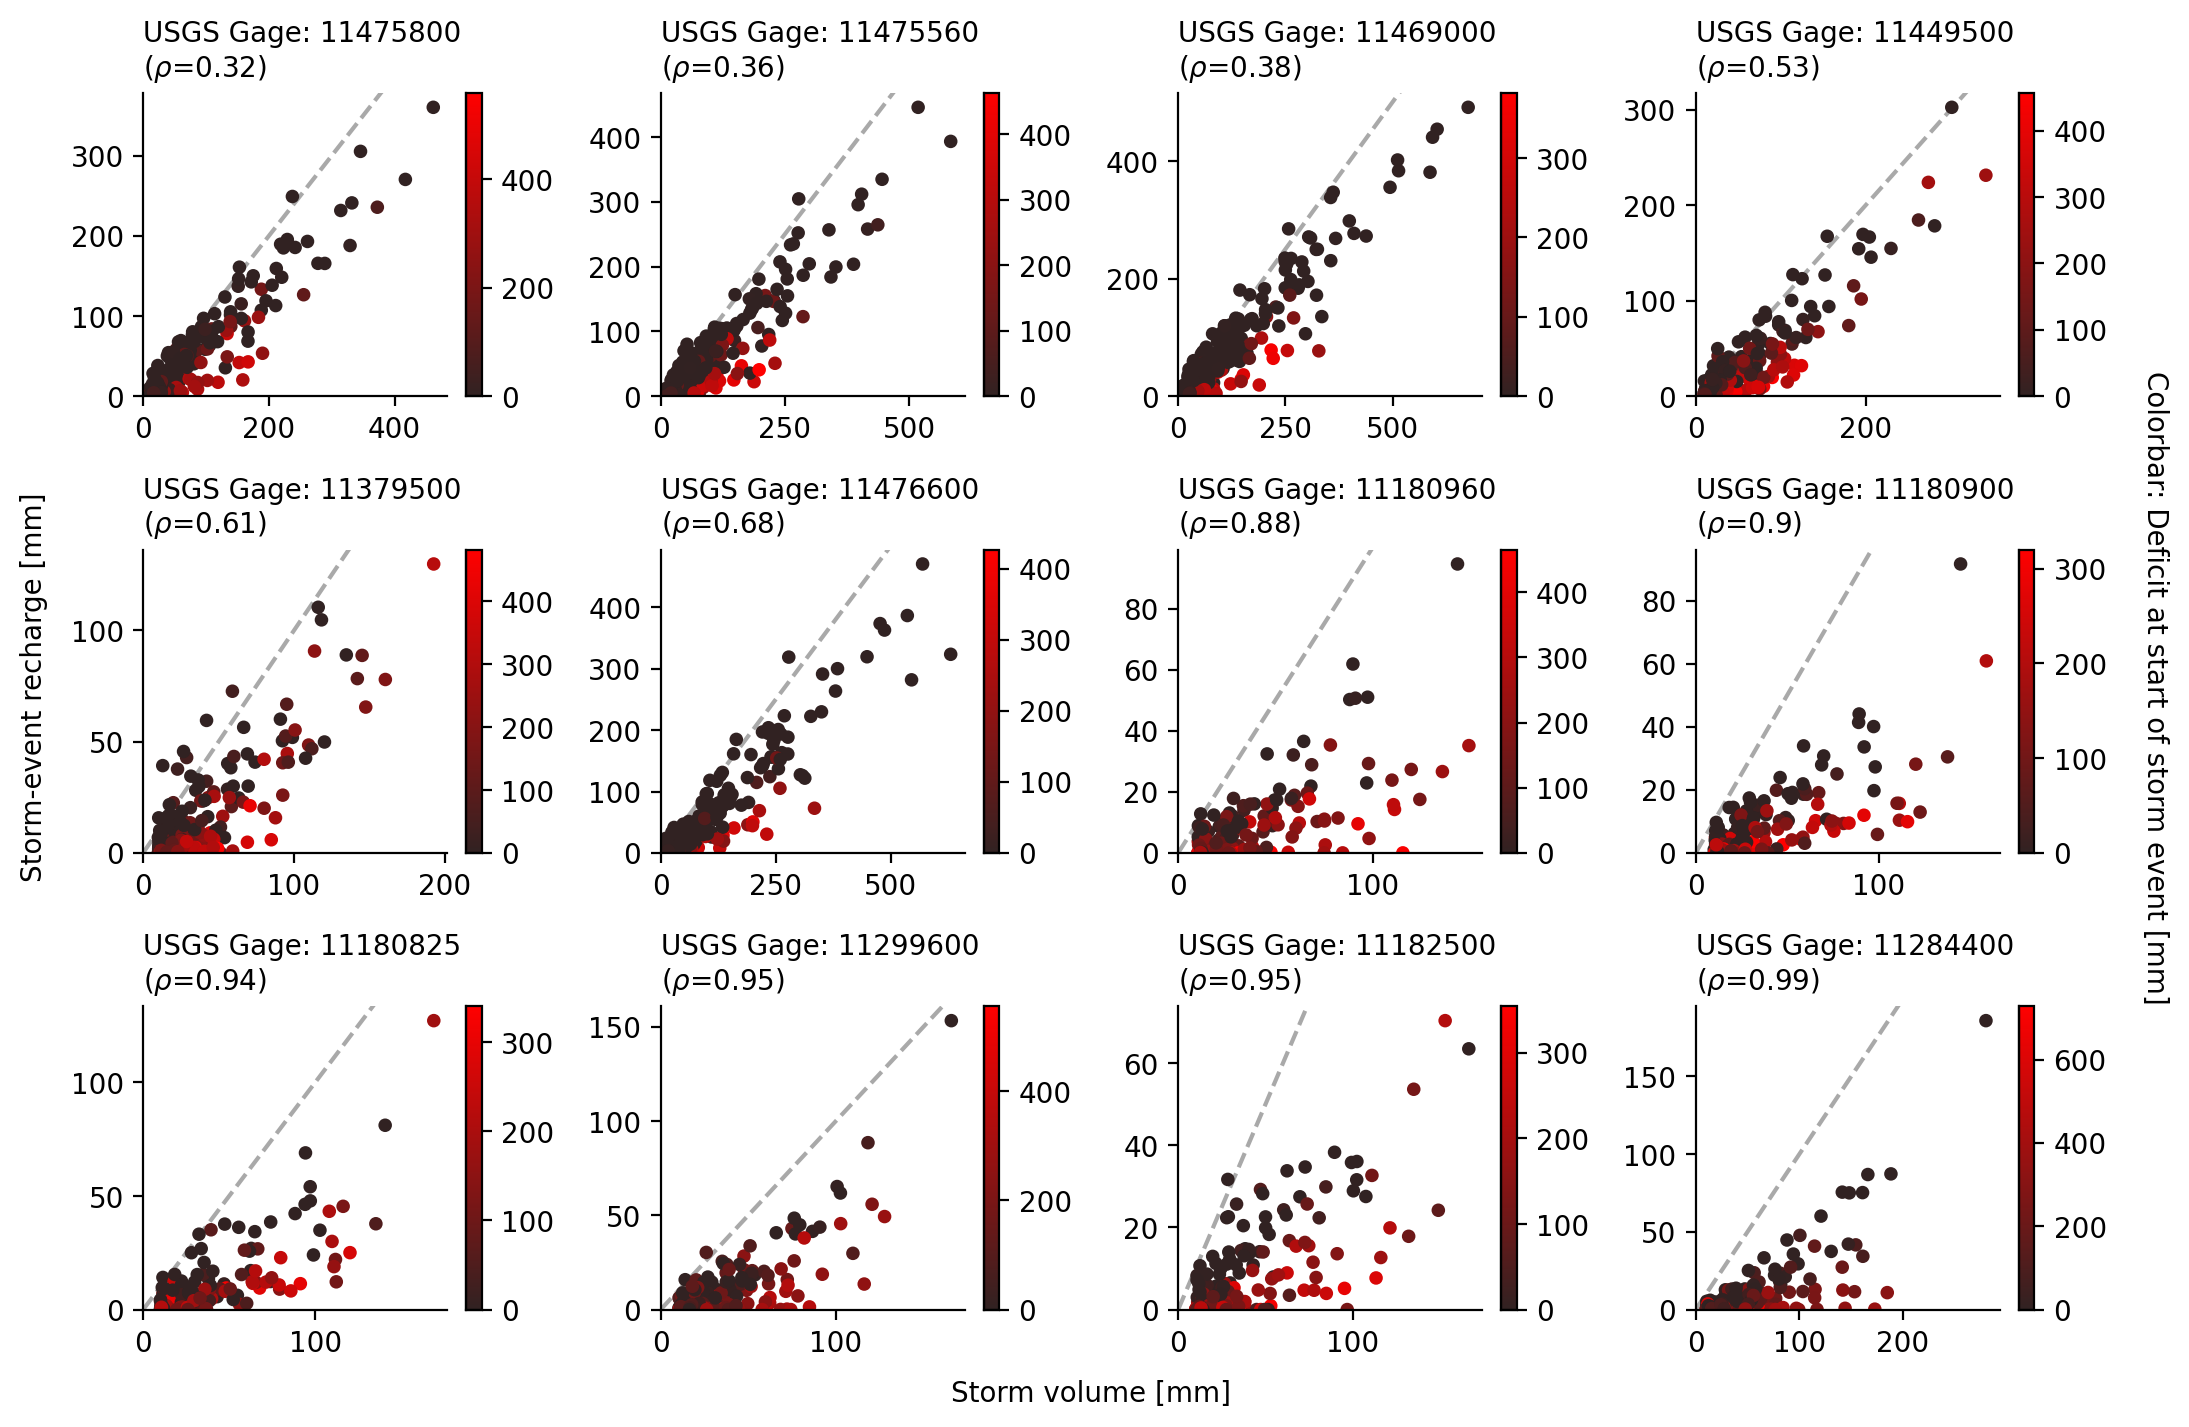

In [17]:
# Plotting space, color map
fig, axs = plt.subplots(3,4,figsize=(10.5,7))
cmap = sns.dark_palette("red", as_cmap=True) # for deficit
# cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume

# Plot
for gage, ax in zip(analysis_gages,axs.ravel()):
  # Event scale fluxes, deficit
  precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage)
  xdata = precip
  ydata = recharge
  colors = deficit
  # Plot data
  data = ax.scatter(xdata,ydata,s=15,c=colors,cmap=cmap)
  axcb = fig.colorbar(data)
  ax.set_xlim(left = 0)
  ax.set_ylim(bottom = 0)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Title handling
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))
  ax.set_title(title, fontsize=10, loc='left')

# Label handling
fig.text(0.5, -0.01, 'Storm volume [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge [mm]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Colorbar: Deficit at start of storm event [mm]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

**Event precipitation - deficit at start of event vs. recharge.**  Colored by storm volume.

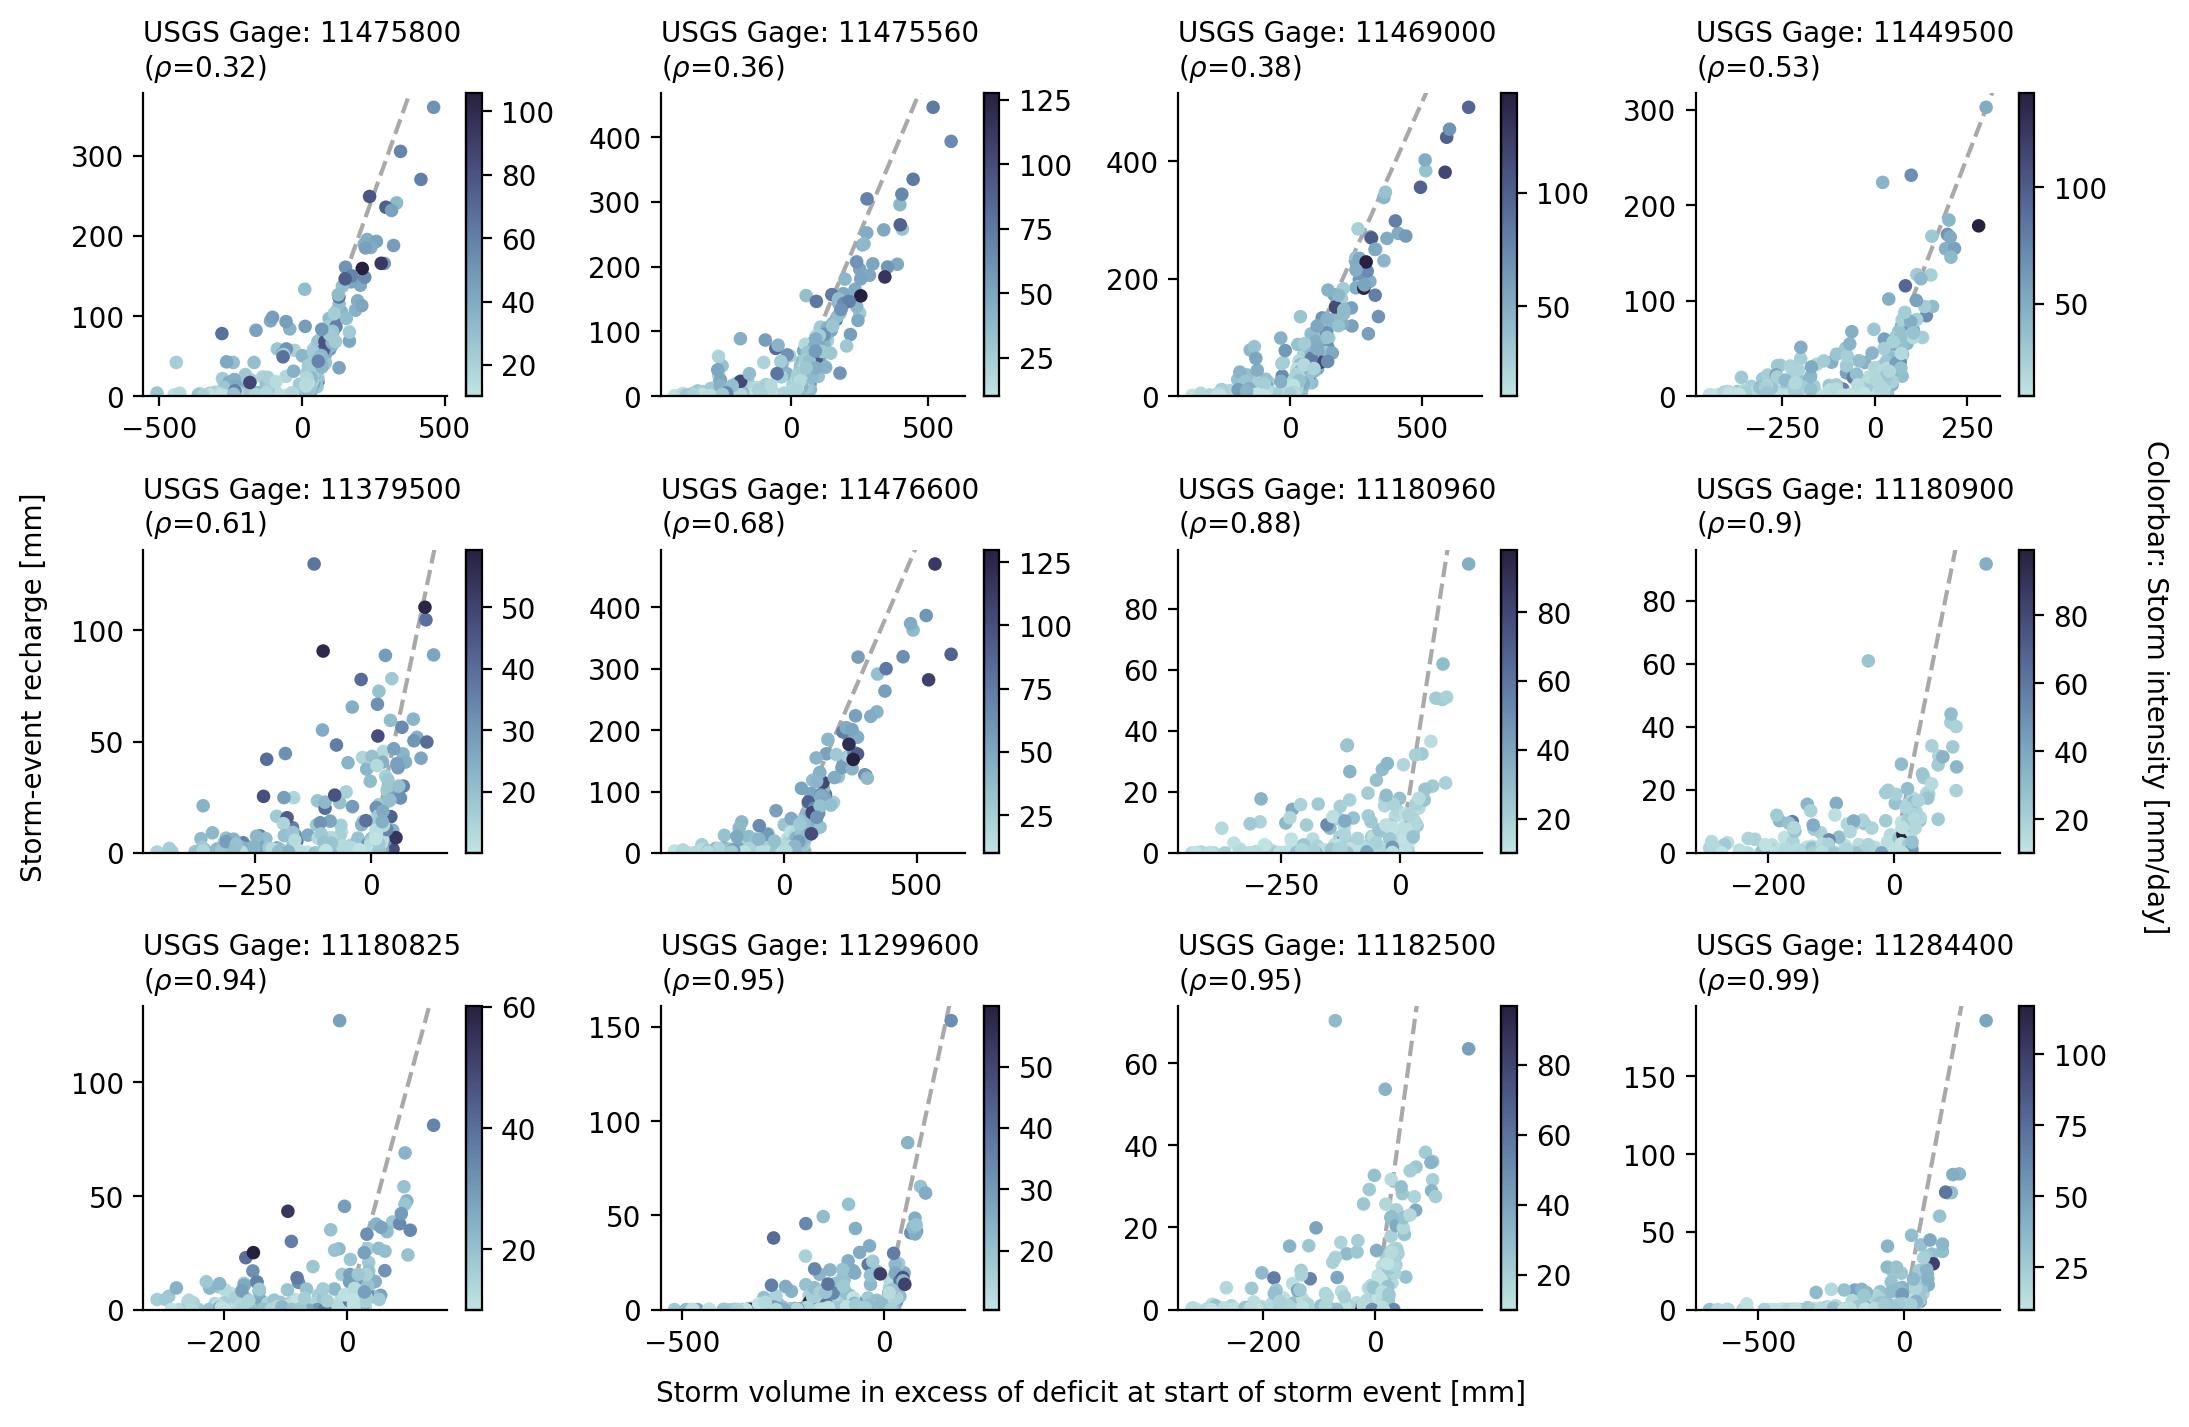

In [18]:
# Plotting space, color map
fig, axs = plt.subplots(3,4,figsize=(10.5,7))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume

# Plot
combined_x = np.array([])
combined_y = np.array([])
combined_c = np.array([])
for gage, ax in zip(analysis_gages,axs.ravel()):
  # Event scale fluxes, deficit
  precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage)
  xdata = precip - deficit
  ydata = recharge
  colors = precip/length
  # Plot data
  data = ax.scatter(xdata,ydata,s=15,c=colors,cmap=cmap)
  axcb = fig.colorbar(data)
  ax.set_ylim(bottom = 0)
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Title handling
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))
  ax.set_title(title, fontsize=10, loc='left')
  # Save for later...
  combined_x = np.append(combined_x,xdata)
  combined_y = np.append(combined_y,ydata)
  combined_c = np.append(combined_c,color)

# Label handling
fig.text(0.5, -0.01, 'Storm volume in excess of deficit at start of storm event [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge [mm]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Colorbar: Storm intensity [mm/day]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

**Storm event recharge ratio vs. deficit at start of event.**

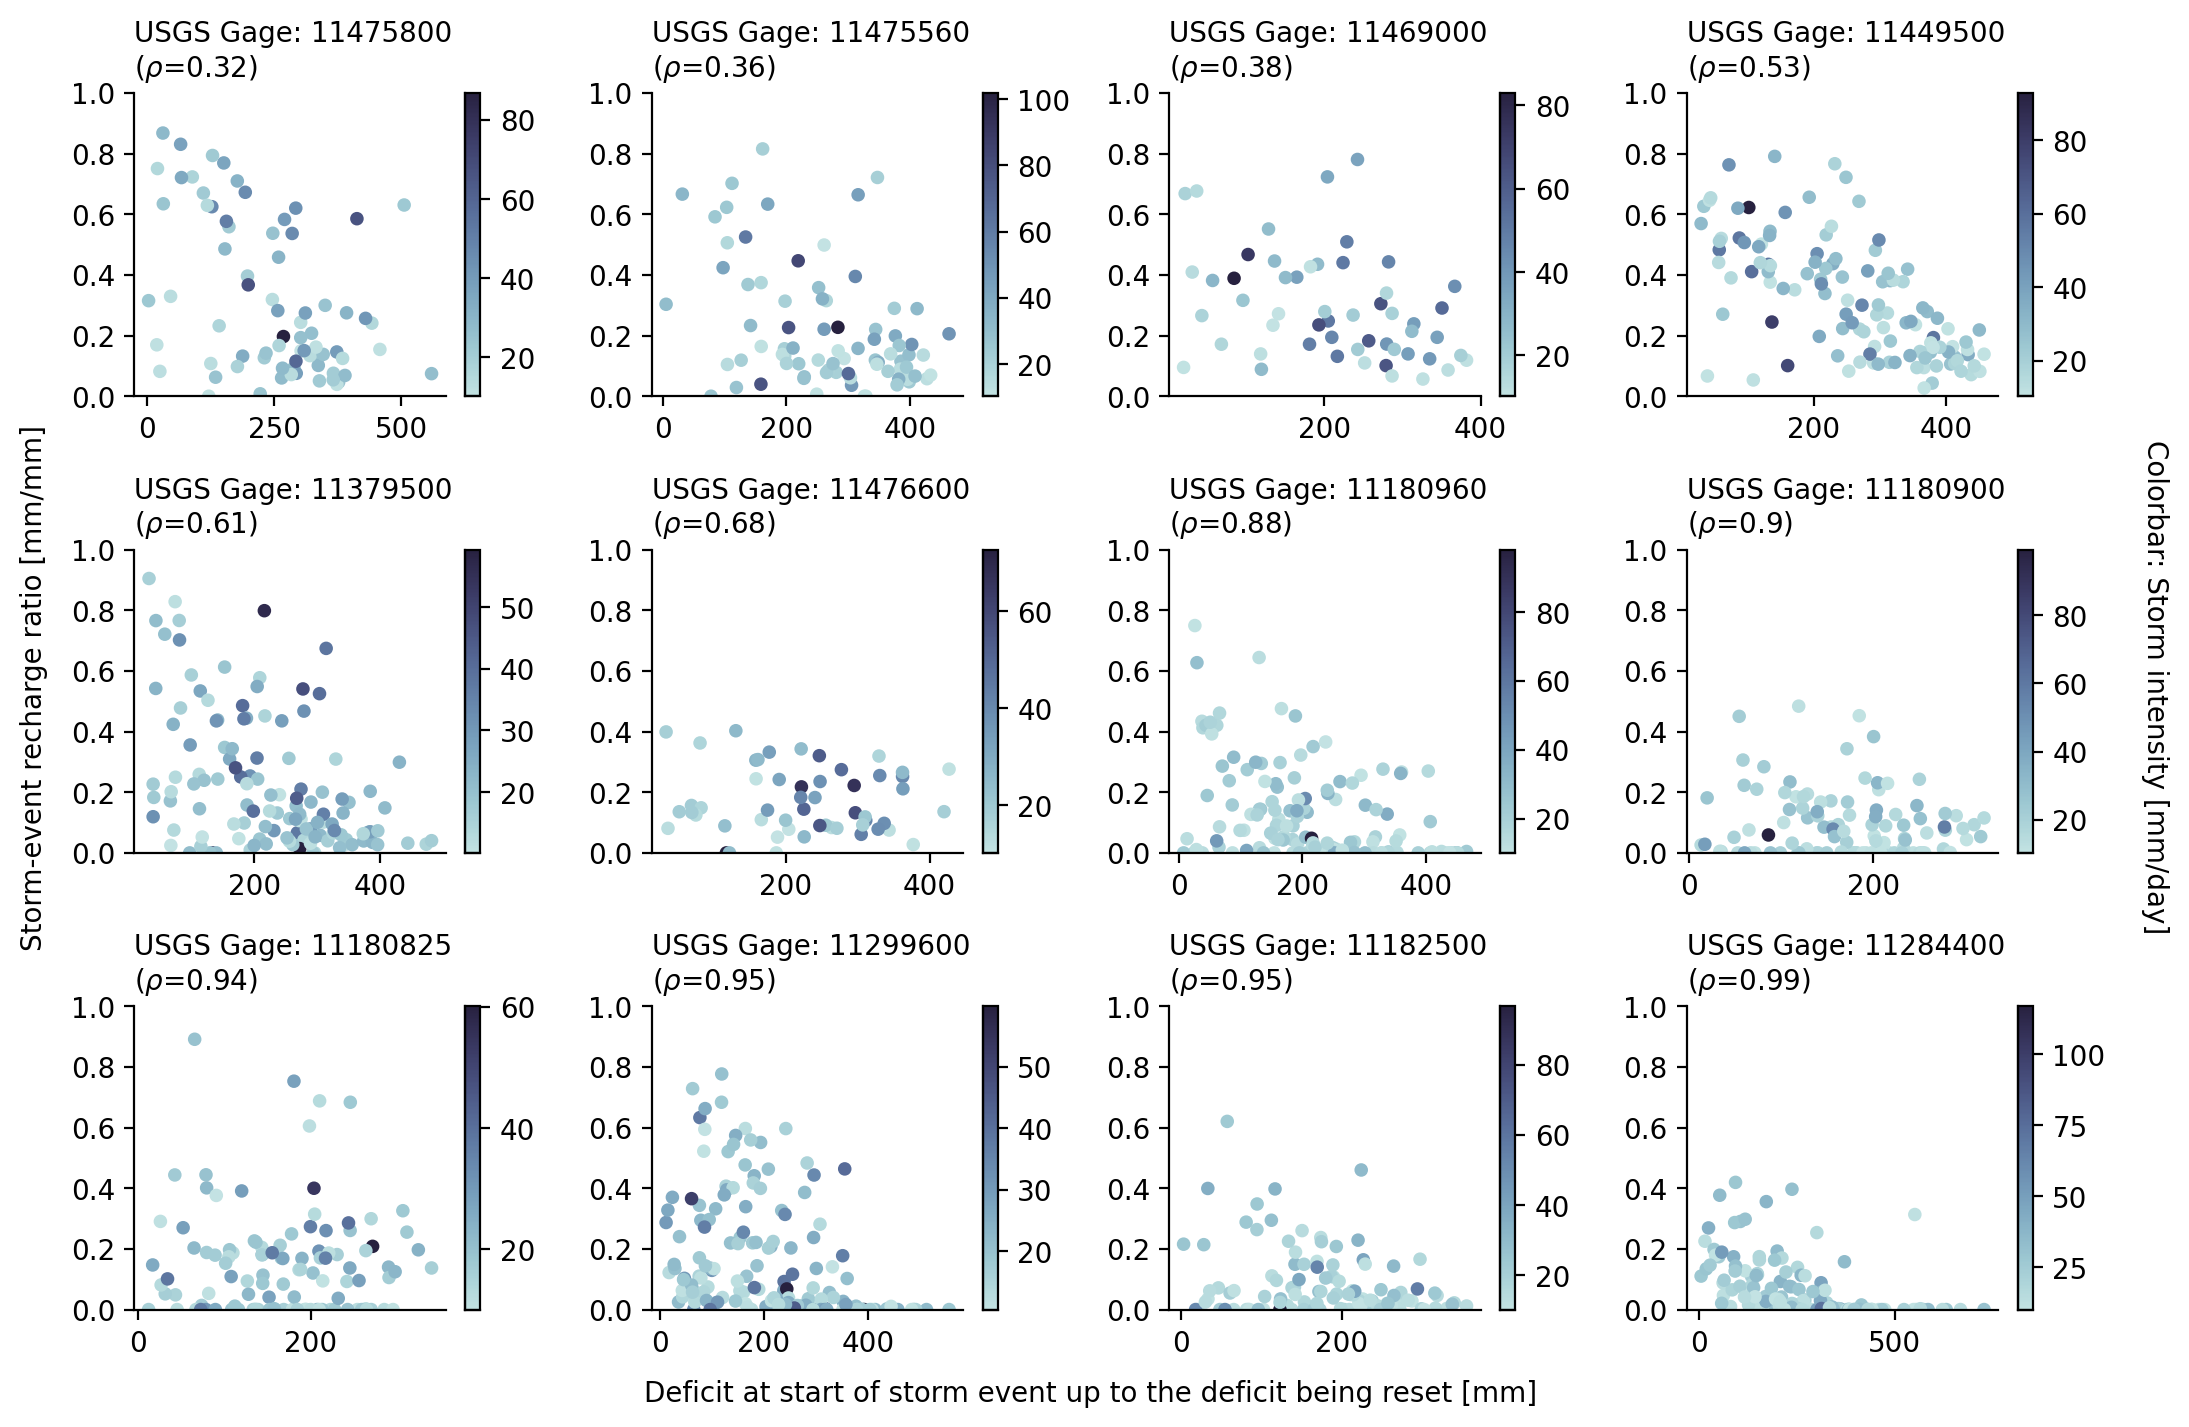

In [19]:
# Plotting space, color map
fig, axs = plt.subplots(3,4,figsize=(10.5,7))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Plot
for gage, ax in zip(analysis_gages,axs.ravel()):
  # Event scale fluxes, deficit
  precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage,to_deficit=True)
  xdata = deficit
  ydata = recharge/precip
  color = precip/length
  # Plot data
  data = ax.scatter(xdata,ydata,s=15,c=color,cmap=cmap)
  axcb = fig.colorbar(data)
  ax.set_ylim([0,1])
  # Title handling
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))
  ax.set_title(title, fontsize=10, loc='left')

# Label handling
fig.text(0.5, -0.01, 'Deficit at start of storm event up to the deficit being reset [mm]', ha='center')
fig.text(-0.01, 0.5, 'Storm-event recharge ratio [mm/mm]', va='center', rotation='vertical')
fig.text(1, 0.5, 'Colorbar: Storm intensity [mm/day]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

**Comparison plot between Elder Creek (USGS gage ID: 11475560) and Big Creek (USGS gage ID: 11284400).**

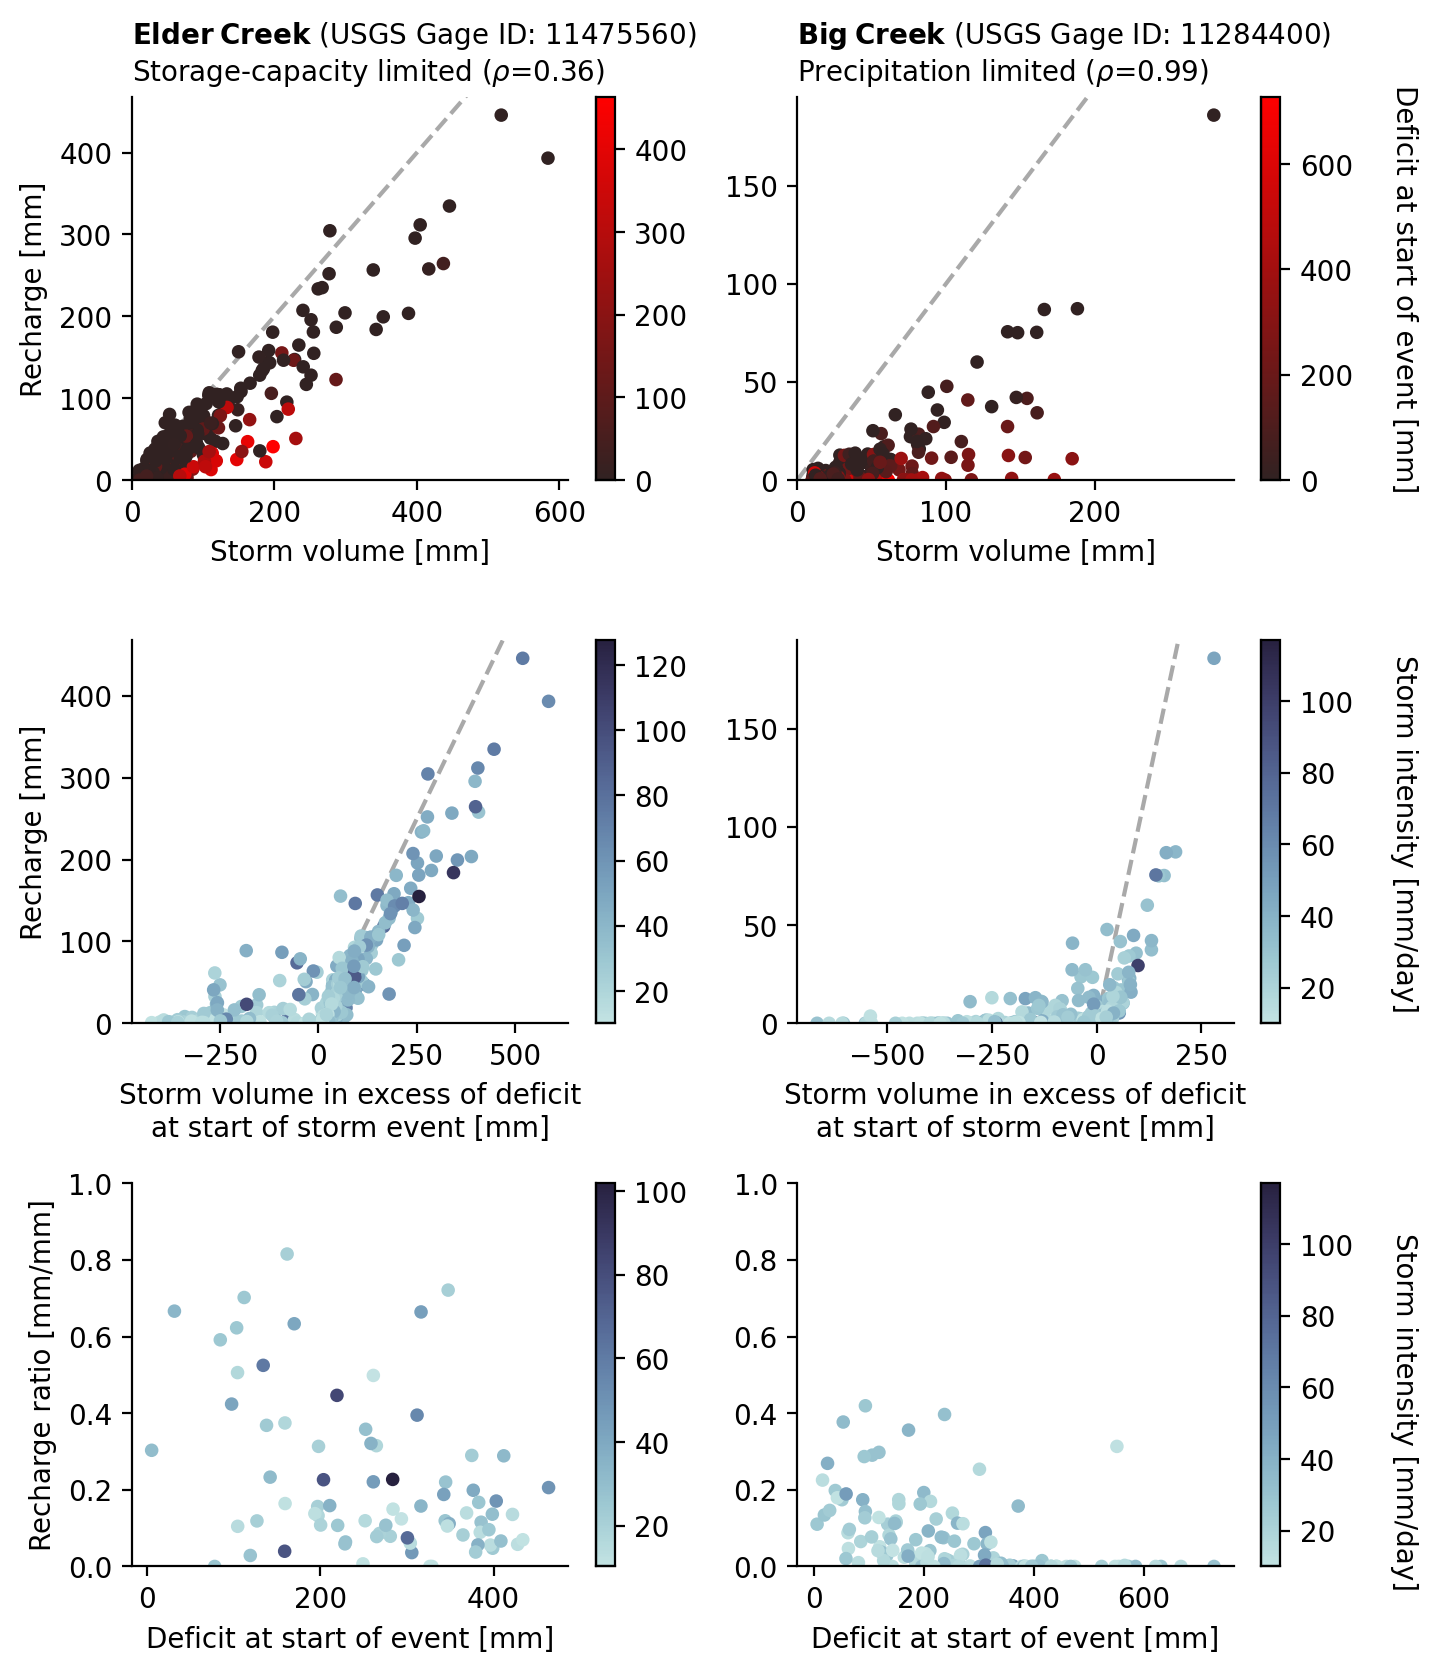

In [20]:
# Plotting space, color map
fig, axs = plt.subplots(3,2,figsize=(7,8.5))
cmap_red = sns.dark_palette("red", as_cmap=True) # for deficit
cmap_blue = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # for storm volume

for gage, c in zip(['11475560','11284400'],[0,1]):
  # Recharge vs. precip
  precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage,to_deficit=False)
  data = axs[0,c].scatter(precip,recharge,s=15,c=deficit,cmap=cmap_red)
  axcb = fig.colorbar(data)
  axs[0,c].set(xlabel="Storm volume [mm]")
  axs[0,c].set_xlim(left=0)
  axs[0,c].set_ylim(bottom=0)

  # Recharge vs. precip-deficit
  data = axs[1,c].scatter(precip-deficit,recharge,s=15,c=precip/length,cmap=cmap_blue)
  axcb = fig.colorbar(data)
  axs[1,c].set(xlabel="Storm volume in excess of deficit\nat start of storm event [mm]")
  axs[1,c].set_ylim(bottom=0)

  # Recharge ratio vs. precip-deficit
  precip, recharge, discharge, deficit, length, years = storm_event_analysis(df_gages,gage,to_deficit=True)
  data = axs[2,c].scatter(deficit,recharge/precip,s=15,c=precip/length,cmap=cmap_blue)
  axcb = fig.colorbar(data)
  axs[2,c].set(xlabel="Deficit at start of event [mm]")
  axs[2,c].set_ylim([0,1])

# 1:1 line
for i in [0,1]:
  for j in [0,1]:
    xmin,xmax = axs[i,j].get_xlim()
    ymin,ymax = axs[i,j].get_ylim()
    axs[i,j].plot([xmin,xmax],[xmin,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
    axs[i,j].set(xlim=[xmin,xmax], ylim=[ymin,ymax])

# Title, label handling
axs[0,0].set_title(r"$\bf{Elder\hspace{0.25}Creek}$"+" (USGS Gage ID: 11475560)\nStorage-capacity limited "+r"($\rho$=0.36)", loc='left', fontsize=10)
axs[0,1].set_title(r"$\bf{Big\hspace{0.25}Creek}$"+" (USGS Gage ID: 11284400)\nPrecipitation limited "+r"($\rho$=0.99)", loc='left', fontsize=10)
axs[0,0].set(ylabel="Recharge [mm]")
axs[1,0].set(ylabel="Recharge [mm]")
axs[2,0].set(ylabel="Recharge ratio [mm/mm]")
fig.text(1, 0.16, 'Storm intensity [mm/day]', va='center', rotation=-90)
fig.text(1, 0.5, 'Storm intensity [mm/day]', va='center', rotation=-90)
fig.text(1, 0.82, 'Deficit at start of event [mm]', va='center', rotation=-90)

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

#**References**
Hahm, W. J., Dralle, D. N., Rempe, D. M., Bryk, A. B., Thompson, S. E., Dawson, T. E., & Dietrich, W. E. (2019). Low Subsurface Water Storage Capacity Relative to Annual Rainfall Decouples Mediterranean Plant Productivity and Water Use From Rainfall Variability. Geophysical Research Letters, 46(12), 6544–6553. https://doi.org/10.1029/2019GL083294

